<a href="https://colab.research.google.com/github/paulpark6/WildFire/blob/main/WF_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Prediction v0.1

# Import Packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/EY - Wildfires in Alberta/fp-historical-wildfire-data-2006-2021.csv'
df_og = pd.read_csv(file_path)
df_og.isnull().sum()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


fire_year                           0
fire_number                         0
fire_name                       22310
current_size                        0
size_class                          0
fire_location_latitude              0
fire_location_longitude             0
fire_origin                         9
general_cause_desc                  0
industry_identifier_desc        22506
responsible_group_desc          13883
activity_class                   8710
true_cause                      10426
fire_start_date                   620
det_agent                           1
det_agent_type                      1
discovered_date                  3978
discovered_size                 22914
reported_date                       1
dispatched_resource                 6
dispatch_date                       6
start_for_fire_date                 7
assessment_resource                 0
assessment_datetime                 0
assessment_hectares                 0
fire_spread_rate                 2609
fire_type   

# Trend in Fire Sizes in each Regions



In [6]:
coordinates = df_og[['fire_number', "current_size", "size_class", "fire_start_date", "ex_fs_date"]].dropna()
coordinates
df_og['forest_area'] = df_og['fire_number'].str[0]
forest_area_names = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}
df_og['forest_area_name'] = df_og['forest_area'].map(forest_area_names)

# Average fire size for each region
avg_fire_size = df_og.groupby('forest_area_name')['current_size'].mean().sort_values(ascending=False)
avg_fire_size = avg_fire_size.reset_index(name='avg_current_size')

# # of fire in each size class
fires_by_size_class = df_og.groupby(['forest_area_name', 'size_class']).size().unstack(fill_value=0)

# Calculating the average latitude and longitude for each forest area
avg_coordinates = df_og.groupby('forest_area_name')[['fire_location_latitude', 'fire_location_longitude']].mean()

# Summary of each region
summary_by_area = avg_fire_size.merge(fires_by_size_class, on='forest_area_name', how='left')

# Merging the average coordinates with the summary_by_area DataFrame
summary_with_coords = summary_by_area.merge(avg_coordinates, on='forest_area_name', how='left')

summary_with_coords





forest_area_name  avg_current_size     A     B    C    D    E  \
0    Fort McMurray        954.011559   869   573  138   48   91   
1       High Level        327.326407  1460  1365  313  110  114   
2       Slave Lake        176.035311  1813   981  157   44   44   
3      Peace River         49.664699  1345   482  104   24   20   
4     Lac La Biche         35.492764  1678   815  111   38   21   
5            Edson         22.034140  1423   404   48   14   12   
6       Whitecourt         11.525105   770   275   40    4    6   
7            Rocky         10.963380  1243   342   50   11   11   
8   Grande Prairie          4.955249  1038   379   59    6    4   
9          Calgary          1.252213  3763   209   40    3    2   

   fire_location_latitude  fire_location_longitude  
0               57.318980              -111.680563  
1               58.644413              -116.764614  
2               55.960303              -114.914583  
3               56.791196              -117.634540  
4               55.423533              -111.516745  
5               53.521177              -116.774673  
6               54.298659              -115.905688  
7               52.446260              -115.429781  
8               55.026199              -118.407118  
9               50.740616              -114.765686

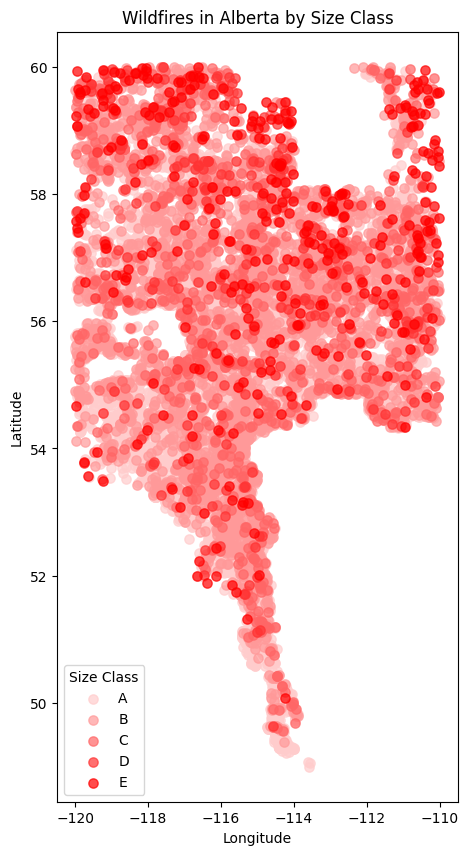

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(df_og, geometry=gpd.points_from_xy(df_og.fire_location_longitude, df_og.fire_location_latitude))
gdf.crs = "EPSG:4326"  # WGS84 Latitude/Longitude

# Creating a simple color map for size classes, using shades of red
color_map = {
    'A': '#ffcccc',  # Lightest red for smallest fires
    'B': '#ff9999',
    'C': '#ff6666',
    'D': '#ff3333',
    'E': '#ff0000'   # Darkest red for largest fires
}
gdf['color'] = gdf['size_class'].map(color_map)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
for size_class, color in color_map.items():
    subset = gdf[gdf['size_class'] == size_class]
    subset.plot(ax=ax, color=color, label=size_class, markersize=45, alpha=0.7)

# Legend
plt.legend(title='Size Class')

plt.title('Wildfires in Alberta by Size Class')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Optional: set xlim and ylim to the bounding coordinates of Alberta for focus
# ax.set_xlim(min_longitude, max_longitude)
# ax.set_ylim(min_latitude, max_latitude)

plt.show()





# Cleaning Dates


In [10]:
# the function will return pd.NaT for null values.
def correct_date_string(date_str):
    # Check if the date_str is not a string (e.g., NaN represented as float)
    if not isinstance(date_str, str):
        return pd.NaT

    # Split the date string into components
    parts = date_str.split('/')

    # Month part of the date, ensuring it's between 1 and 12
    month = parts[0]
    month = str(max(min(int(month), 12), 1)).zfill(2)

    # Day part of the date, ensuring it's between 01 and 31
    day = parts[1]
    day = str(max(min(int(day), 31), 1)).zfill(2)

    # Year part of the date, if the year
    year = parts[2].split(' ')[0]  # Extracting only year
    if len(year) == 4:  # If year is mistakenly input as 4 digits
        year = year[-2:]  # Use last two digits

    # Reconstruct the date string, excluting the time part if present
    corrected_date_str = f"{month}/{day}/{year}"
    if len(parts[2].split(' ')) > 1:
        time_part = parts[2].split(' ')[1]
        corrected_date_str += f" {time_part}"

    return corrected_date_str

In [11]:
# Creating a copy of df_og
df_copy = df_og.copy()

# Apply the correct_date_string function to the 'fire_start_date' and 'ex_fs_date' columns
# Direct assignment to DataFrame columns
df_copy['fire_start_date'] = df_copy['fire_start_date'].apply(correct_date_string)
df_copy['ex_fs_date'] = df_copy['ex_fs_date'].apply(correct_date_string)

# Checking if the 'fire_start_date' is cleaned
print(df_copy.iloc[1291])

fire_year                                    2021
fire_number                                LWF065
fire_name                                     NaN
current_size                                  0.1
size_class                                      A
fire_location_latitude                  54.567167
fire_location_longitude                 -111.1981
fire_origin                       Provincial Land
general_cause_desc                     Incendiary
industry_identifier_desc                      NaN
responsible_group_desc                        NaN
activity_class                              Arson
true_cause                                    NaN
fire_start_date                 04/24/21 12:00:00
det_agent                                    GOVT
det_agent_type                                UNP
discovered_date                      5/9/21 19:00
discovered_size                               NaN
reported_date                        5/9/21 19:00
dispatched_resource                     FPD Staff


# Seasaonality Graph for each FSA Region (By current_size)




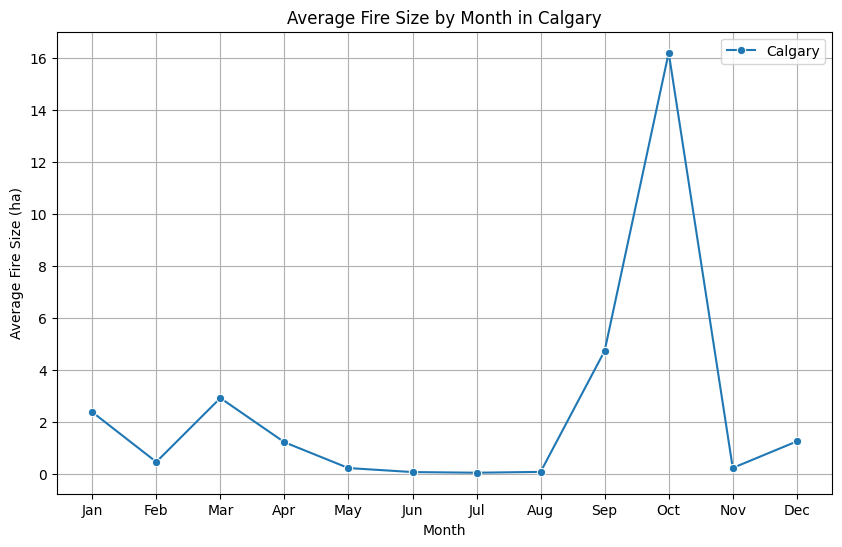

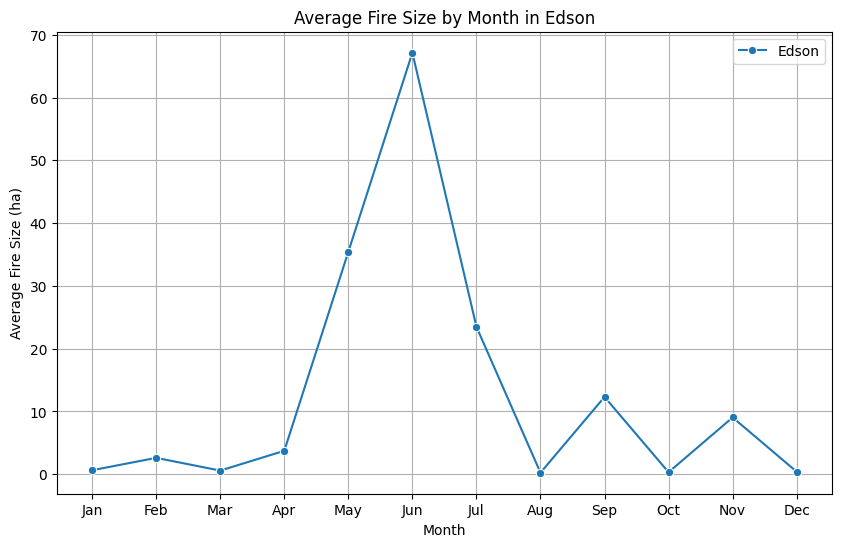

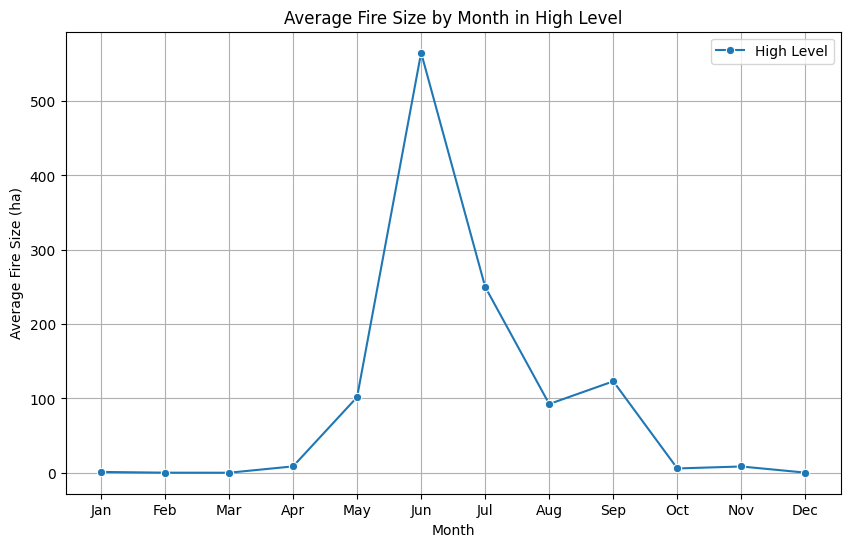

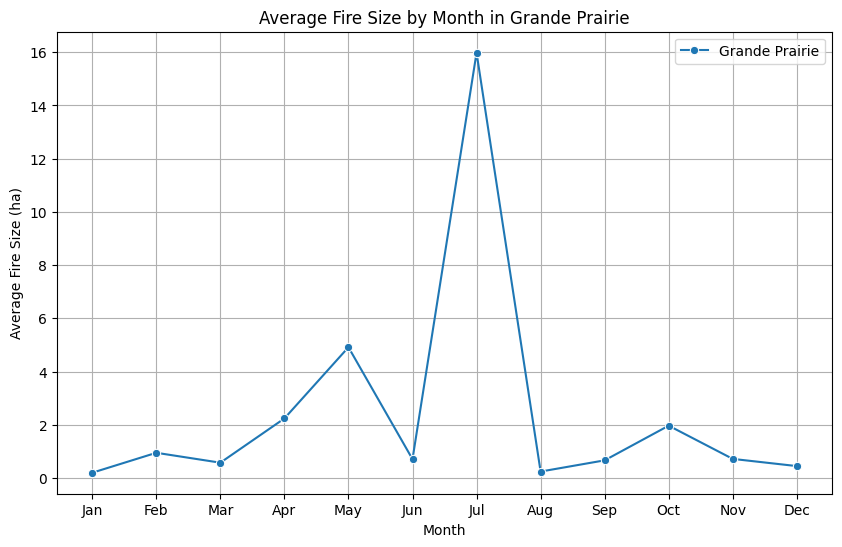

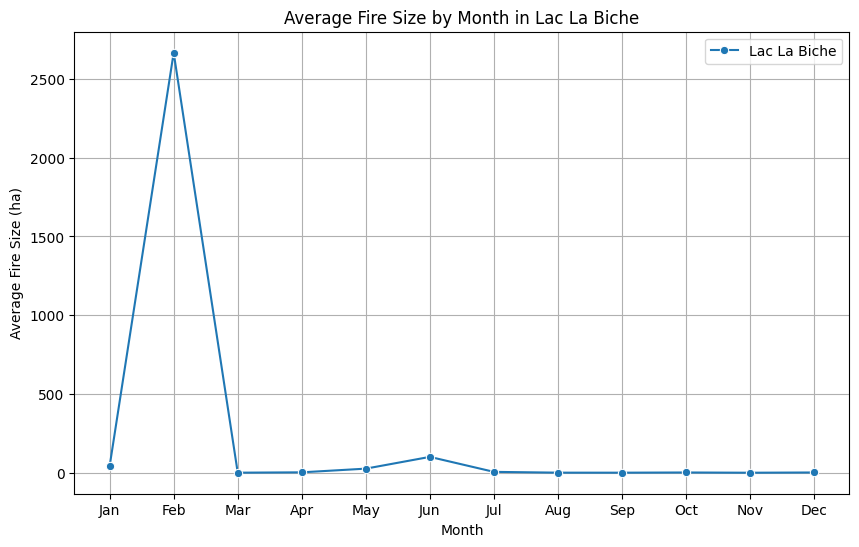

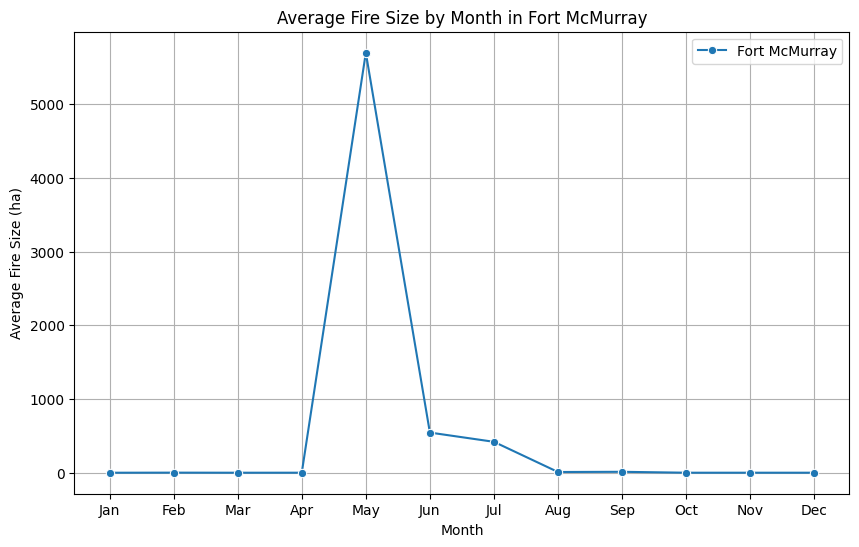

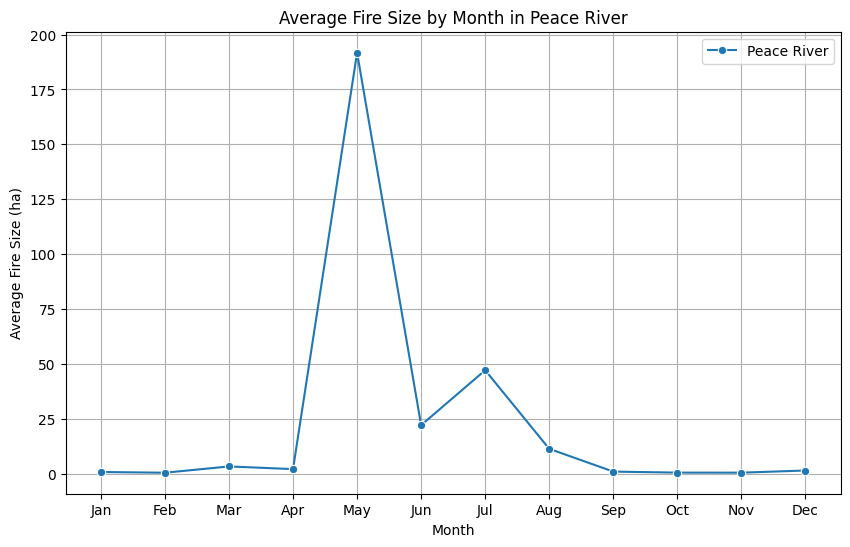

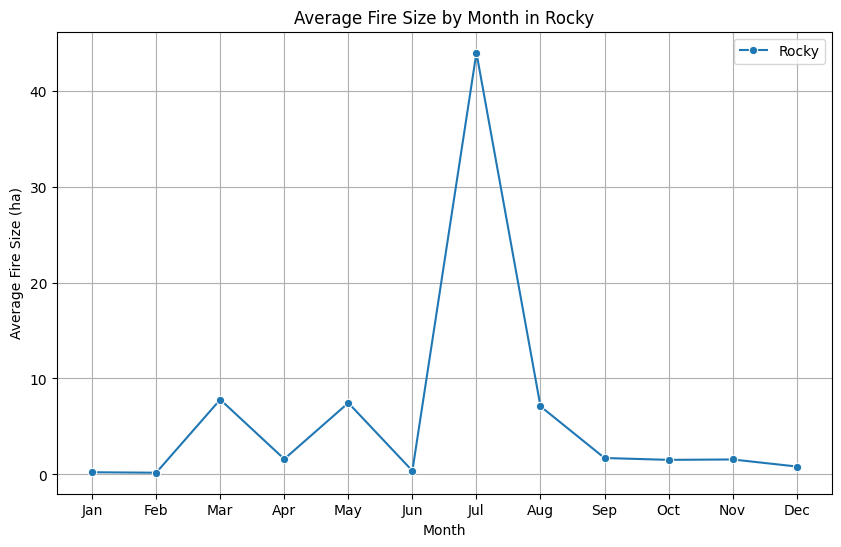

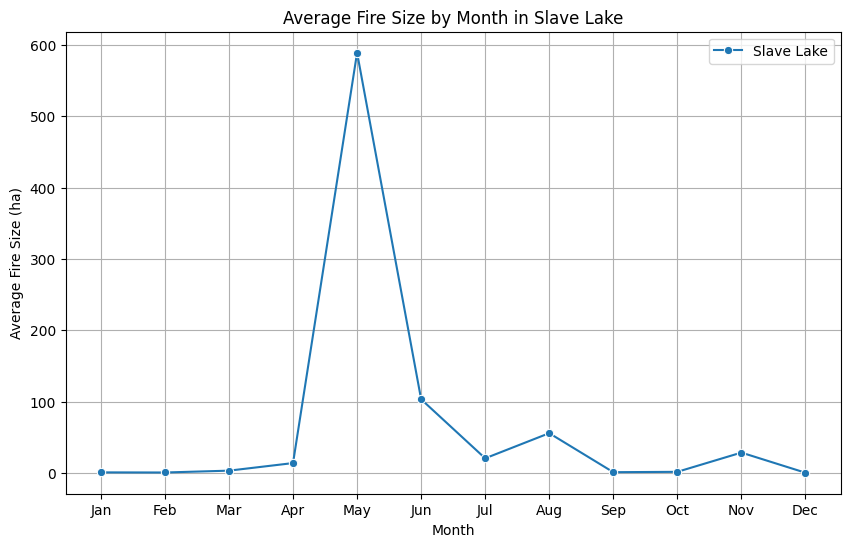

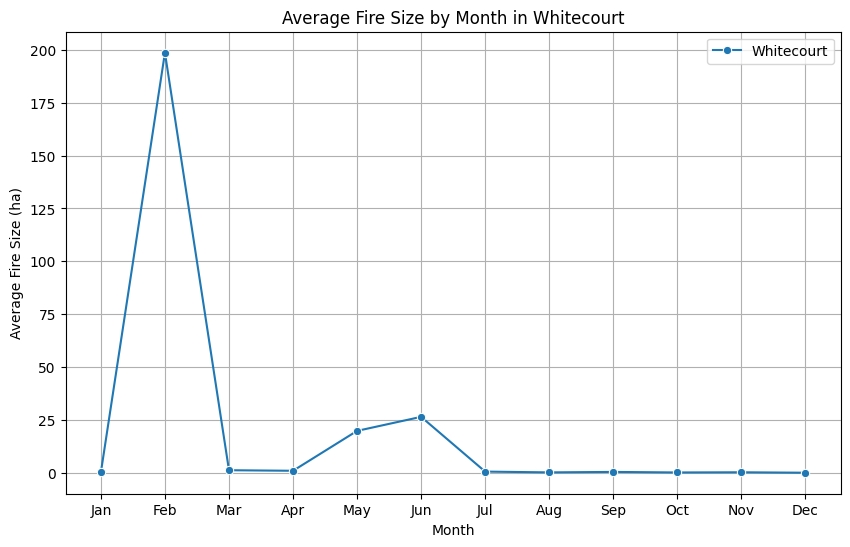

In [14]:
# convering the area code into city names
forest_area_names = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}

df_copy['month'] = pd.to_datetime(df_copy['fire_start_date']).dt.month

# Group data by region and month to calculate the average fire size
seasonality_month_size_data = df_copy.groupby(['forest_area_name', 'month'])['current_size'].mean().reset_index()

# Sort by month for proper sequential plotting
seasonality_month_size_data['month'] = pd.Categorical(seasonality_month_size_data['month'], categories=[i for i in range(1, 13)], ordered=True)

for region_code, region_name in forest_area_names.items():
    region_data = seasonality_month_size_data[seasonality_month_size_data['forest_area_name'] == region_name].copy()

    # Ensure the data is sorted by month for correct plotting
    region_data.sort_values('month', inplace=True)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=region_data, x='month', y='current_size', marker='o', label=region_name)

    plt.title(f'Average Fire Size by Month in {region_name}')
    plt.xlabel('Month')
    plt.ylabel('Average Fire Size (ha)')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.legend()
    plt.show()



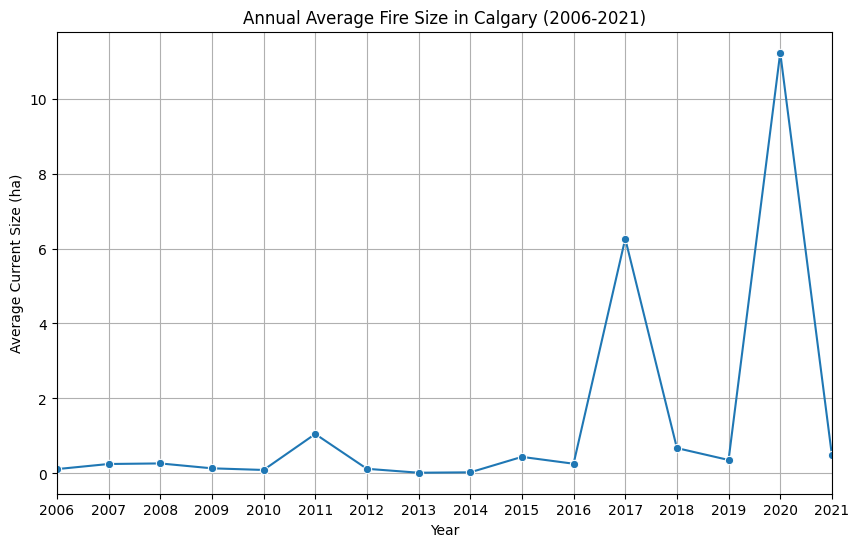

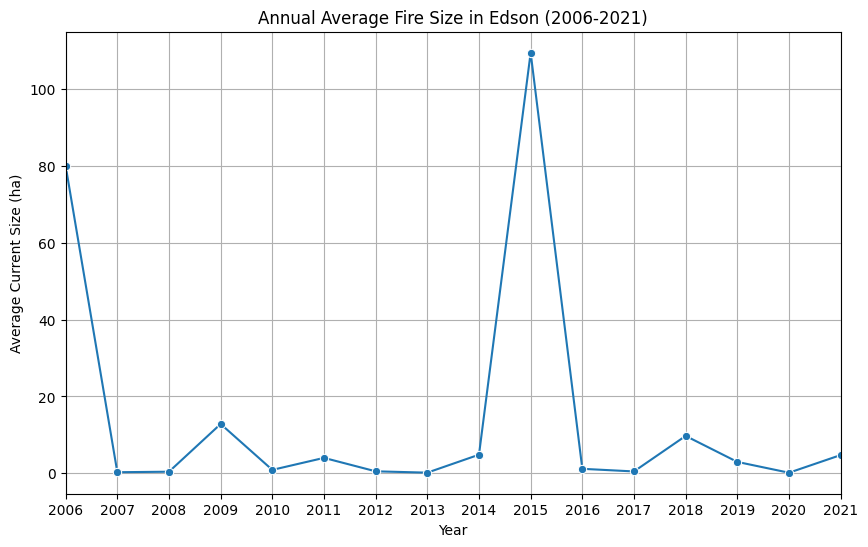

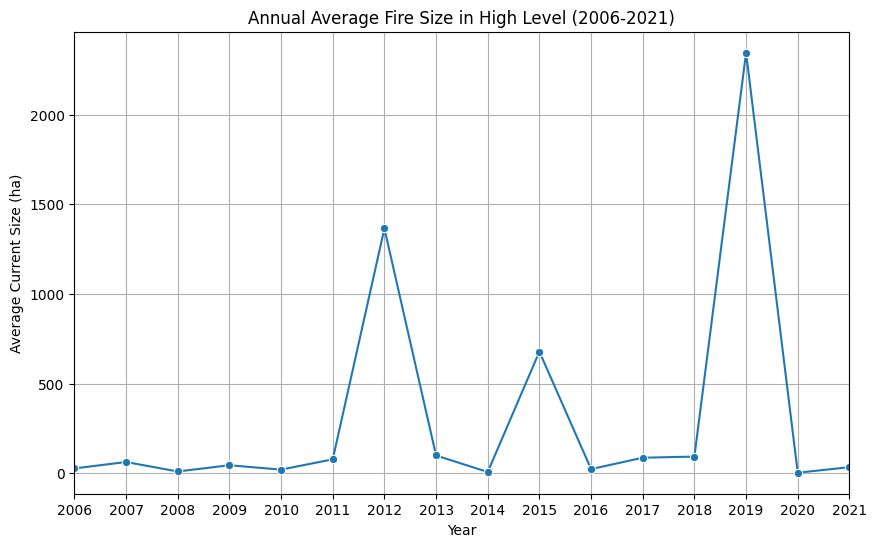

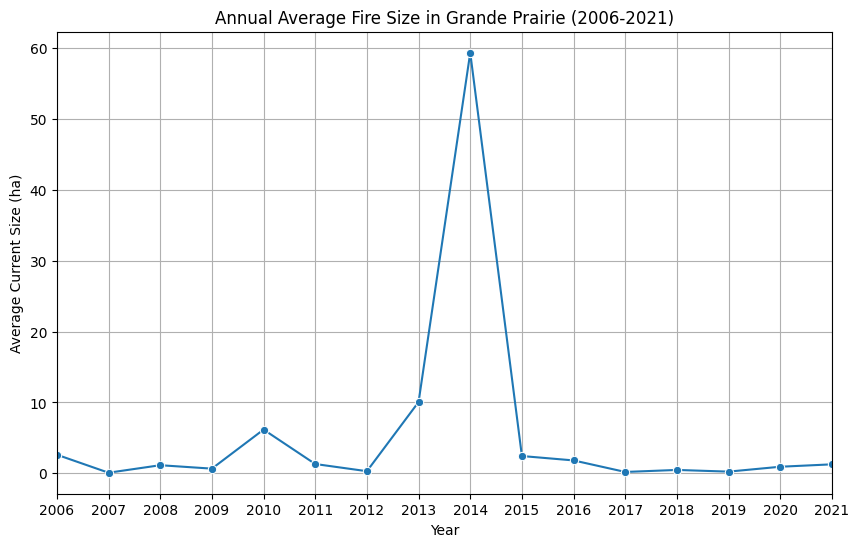

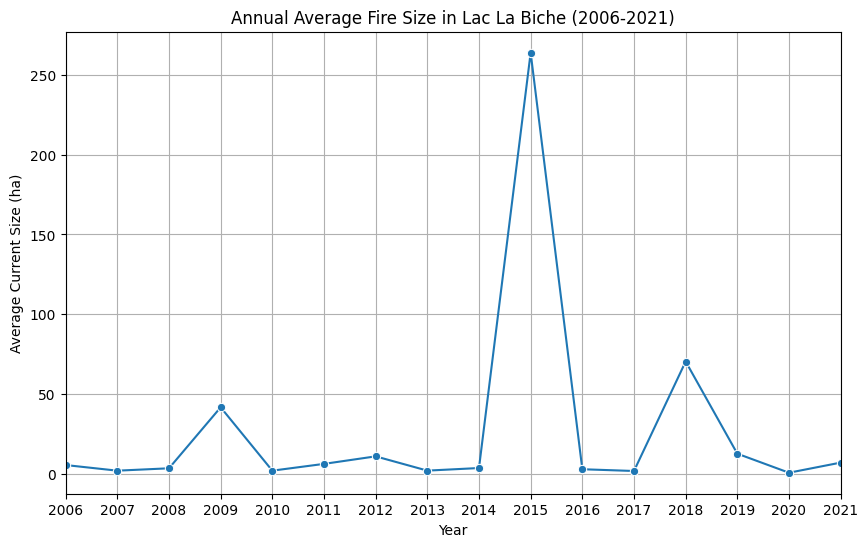

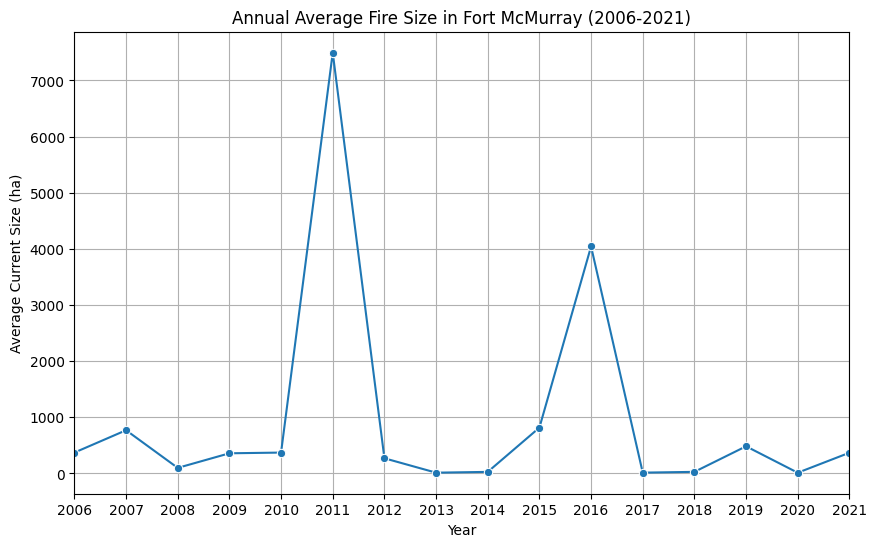

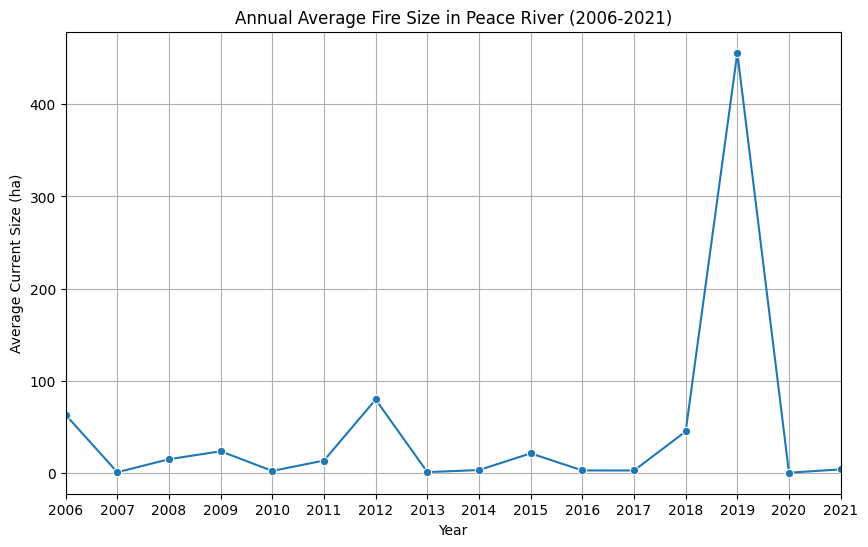

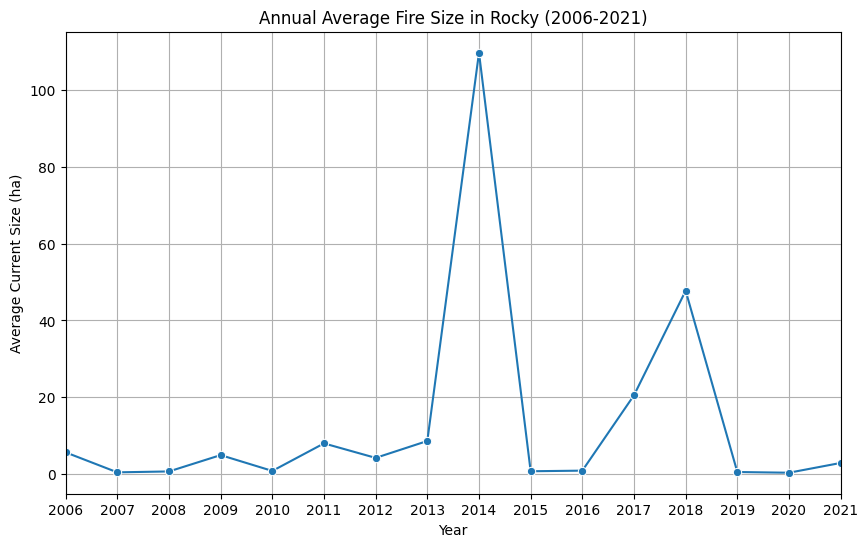

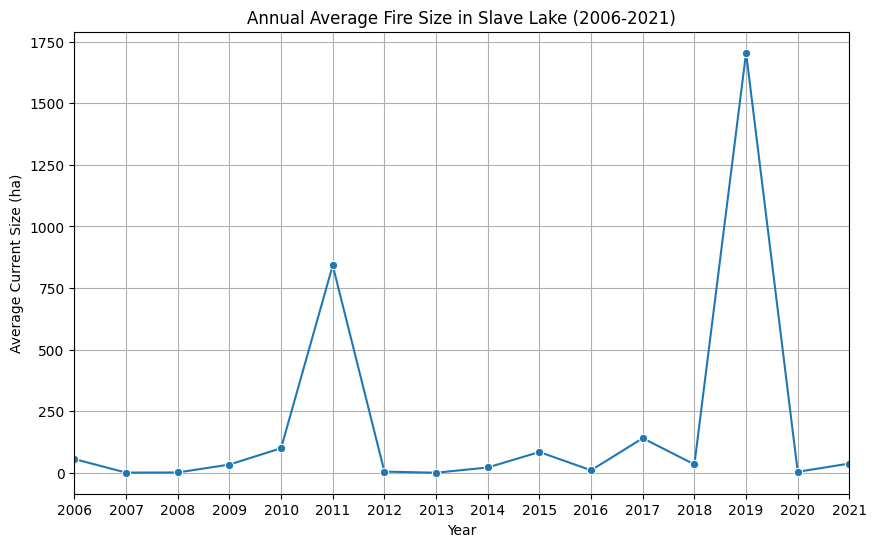

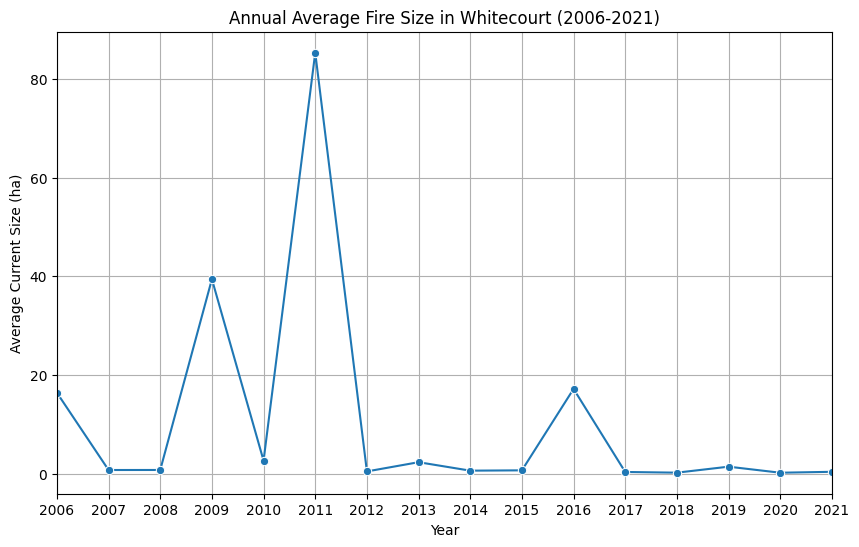

In [15]:
seasonality_year_size_data = df_copy.groupby(['forest_area_name', 'fire_year'])['current_size'].mean().reset_index()

for region_code, region_name in forest_area_names.items():
    # Filter data for the current region
    region_data = seasonality_year_size_data[seasonality_year_size_data['forest_area_name'] == region_name]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=region_data, x='fire_year', y='current_size', marker='o')

    plt.title(f'Annual Average Fire Size in {region_name} (2006-2021)')
    plt.xlabel('Year')
    plt.ylabel('Average Current Size (ha)')
    plt.xlim(2006, 2021)
    plt.xticks(range(2006, 2022))
    plt.grid(True)
    plt.show()

# Seasonality Graph for each FSA Region (By size_class)

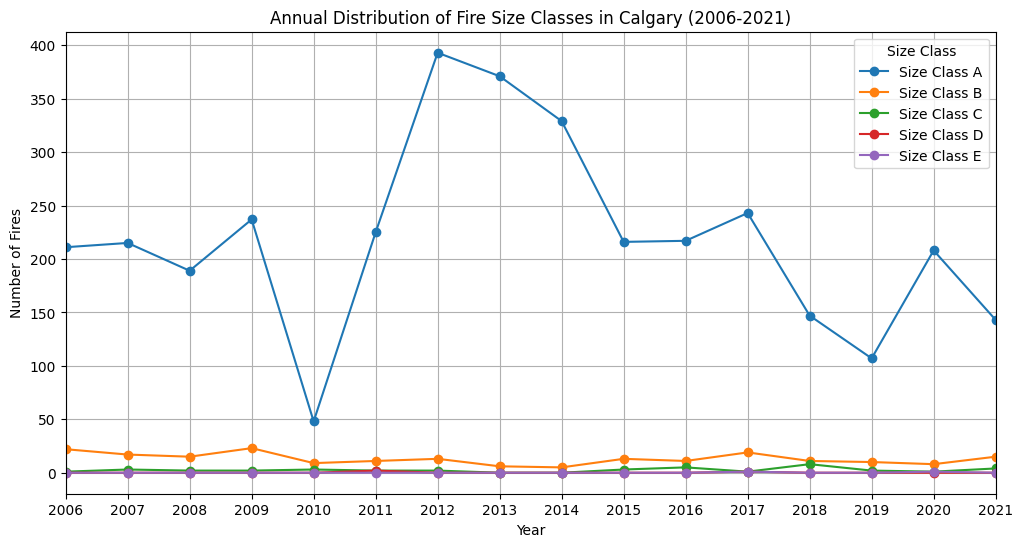

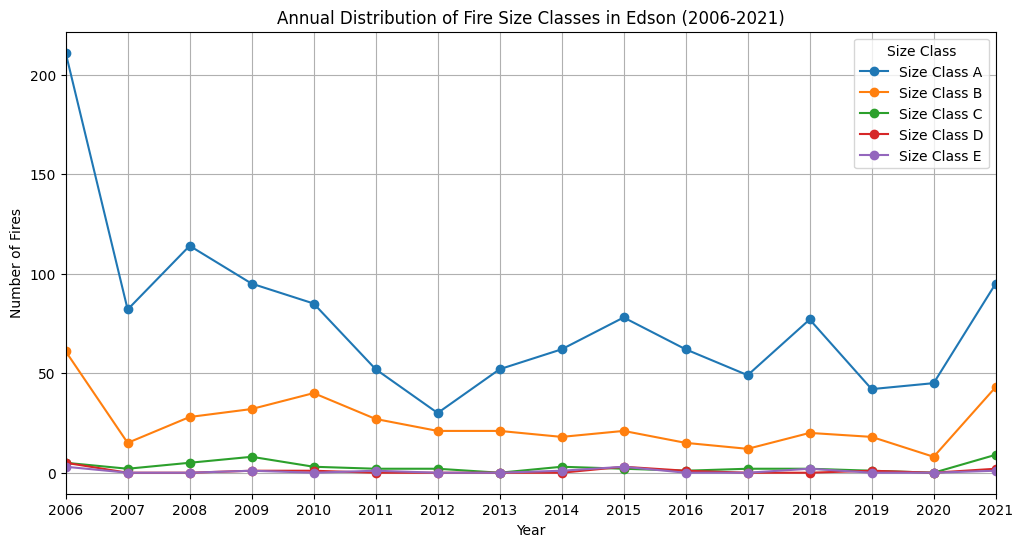

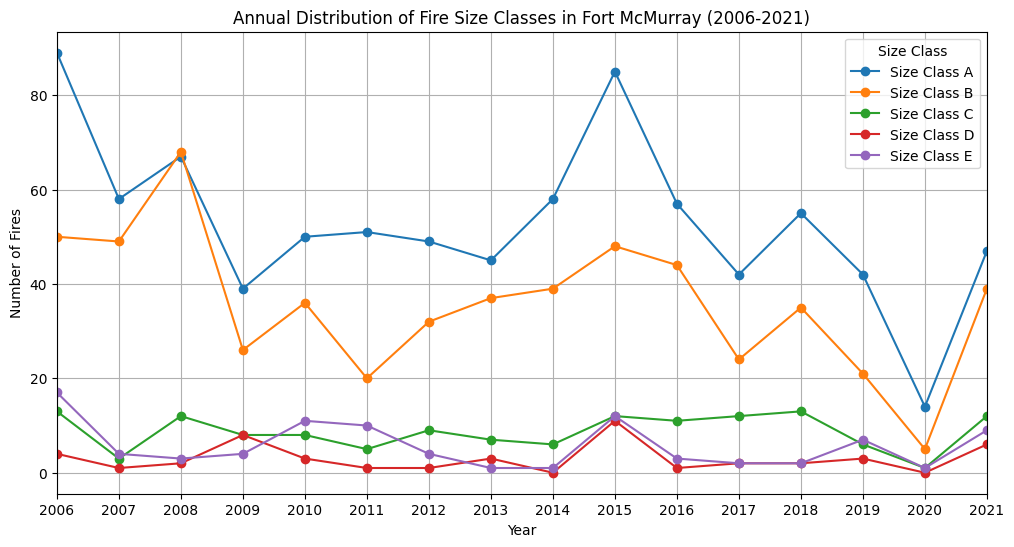

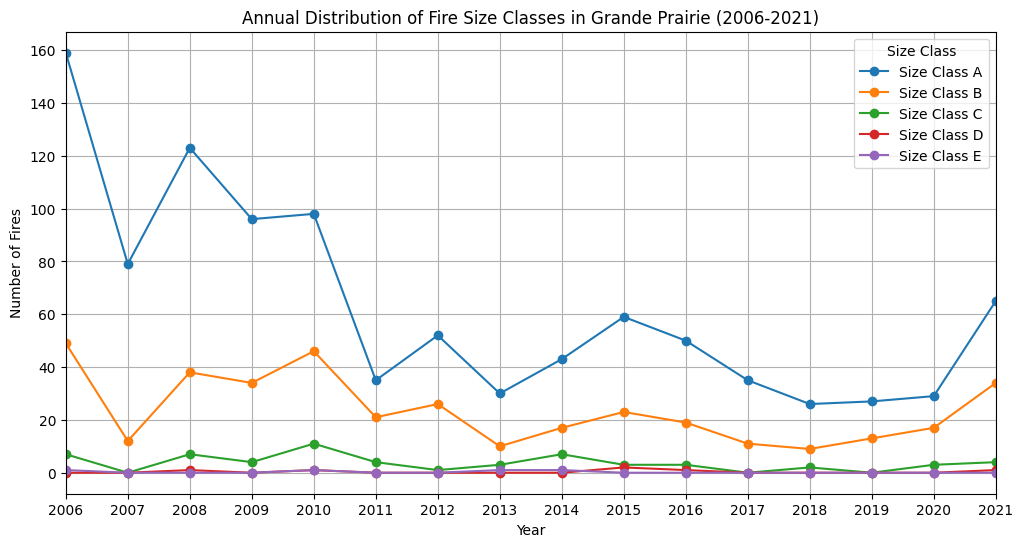

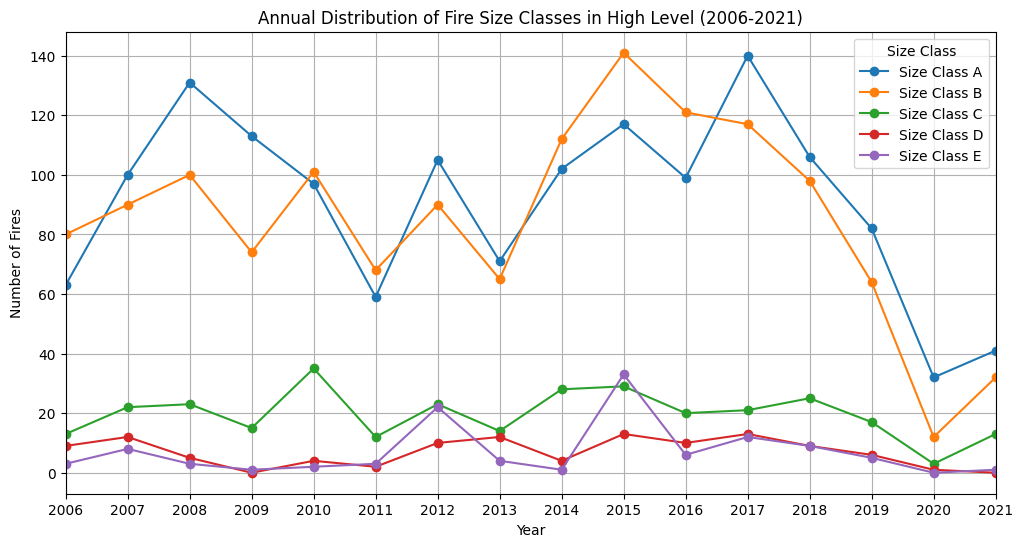

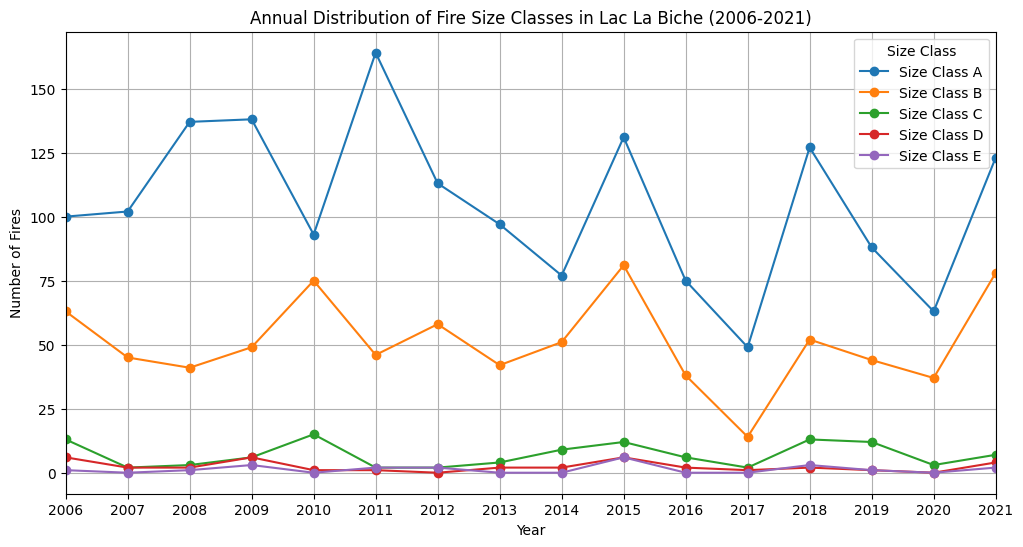

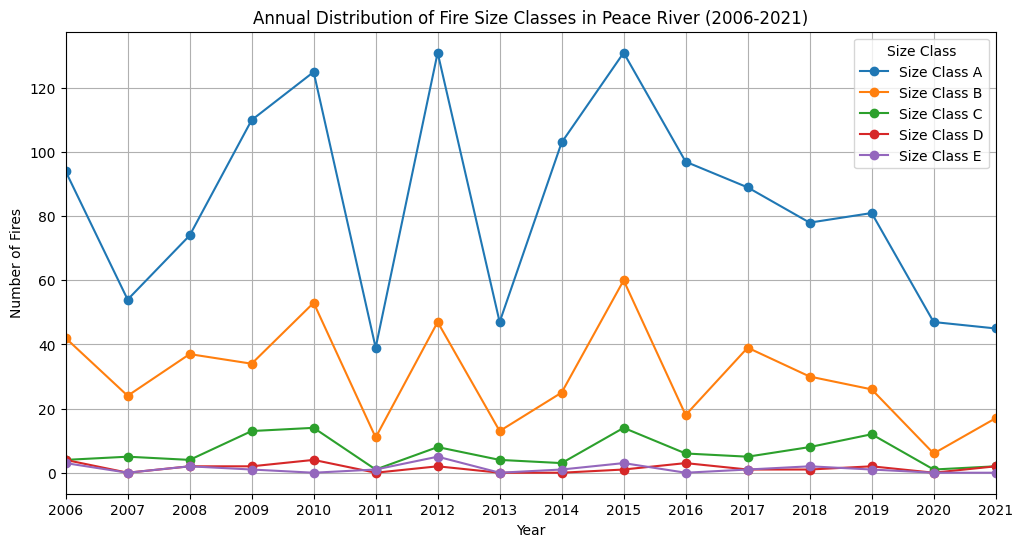

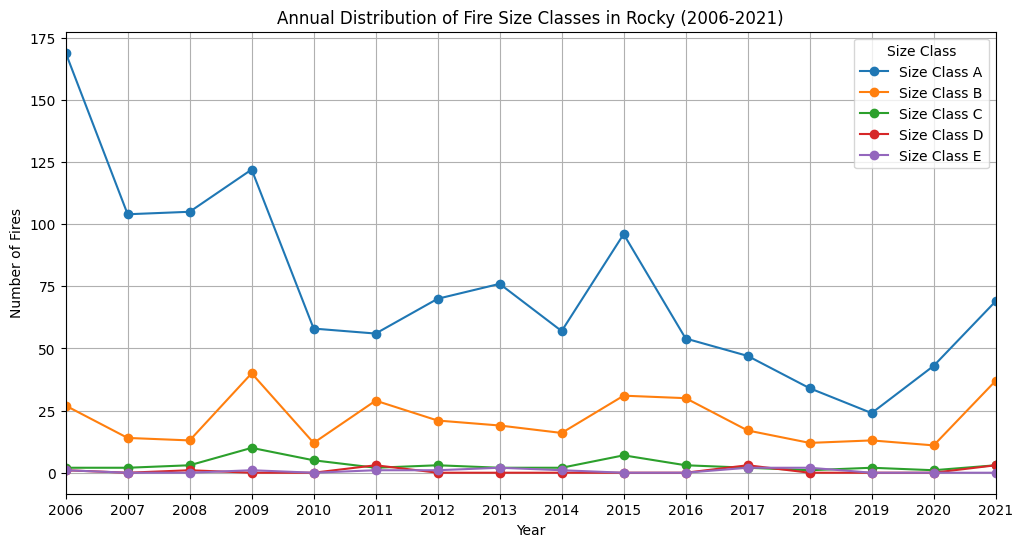

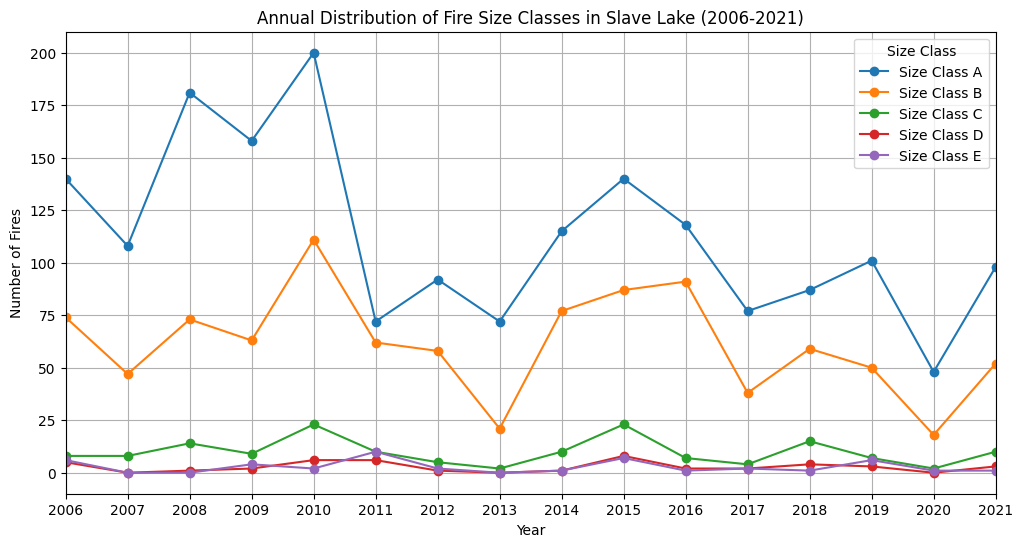

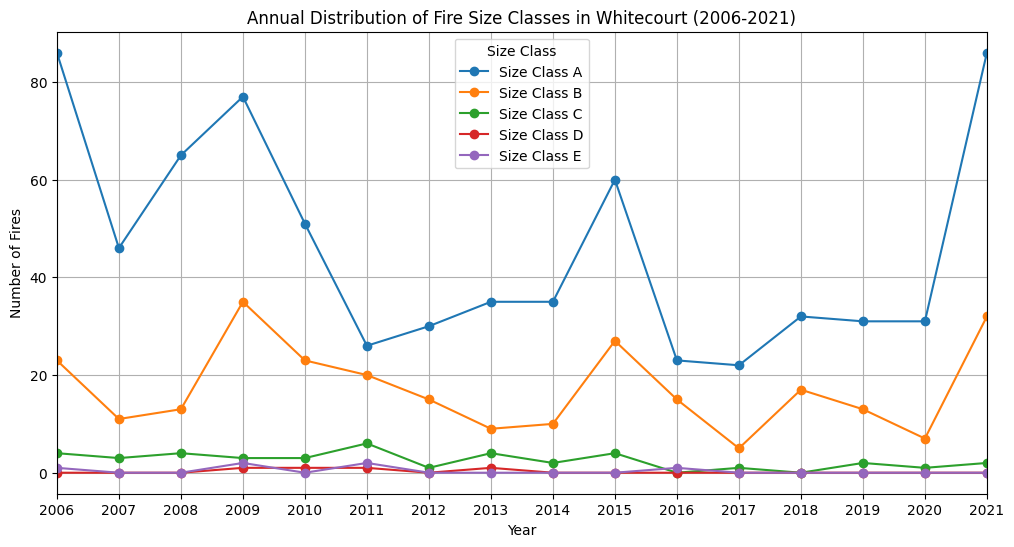

In [ ]:
yearly_class_data = df_copy.groupby(['forest_area_name', 'fire_year', 'size_class']).size().reset_index(name='count')

pivot_class_data = yearly_class_data.pivot_table(index=['forest_area_name', 'fire_year'],
                                                      columns='size_class',
                                                      values='count',
                                                      fill_value=0).reset_index()

# Unique list of FSA regions from the pivot table
fsa_regions = pivot_class_data['forest_area_name'].unique()

# Loop through each FSA region to create a plot
for region in fsa_regions:
    # Filter data for the current region
    region_data = pivot_class_data[pivot_class_data['forest_area_name'] == region]

    plt.figure(figsize=(12, 6))

    # Plot each size class as a separate line
    for size_class in region_data.columns[2:]:  # Skip 'forest_area_name' and 'year' columns
        plt.plot(region_data['fire_year'], region_data[size_class], marker='o', label=f'Size Class {size_class}')

    plt.title(f'Annual Distribution of Fire Size Classes in {region} (2006-2021)')
    plt.xlabel('Year')
    plt.ylabel('Number of Fires')
    plt.xlim(2006, 2021)
    plt.xticks(range(2006, 2022))  # Ensuring x-ticks for each year
    plt.legend(title='Size Class')
    plt.grid(True)
    plt.show()

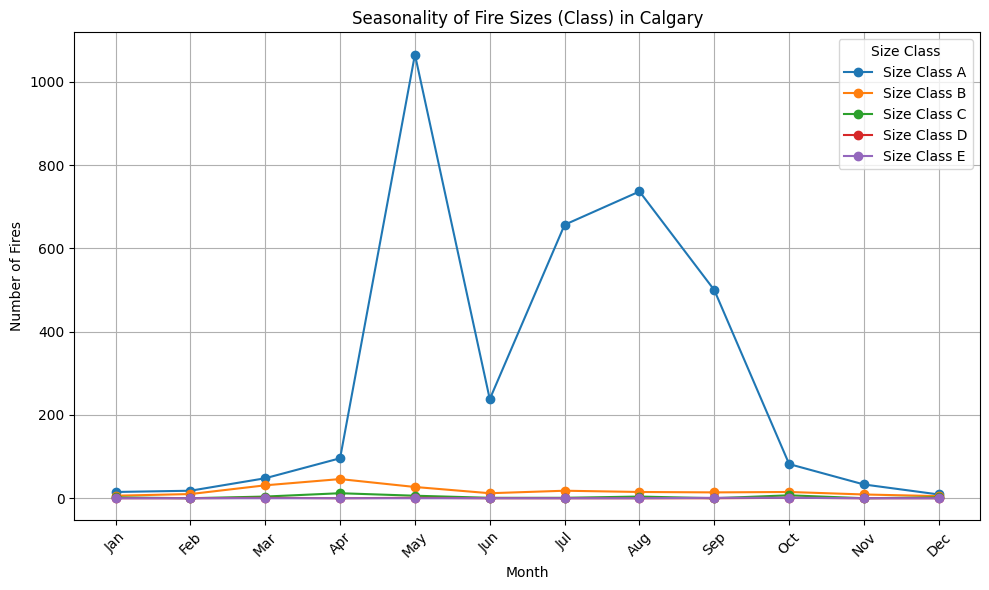

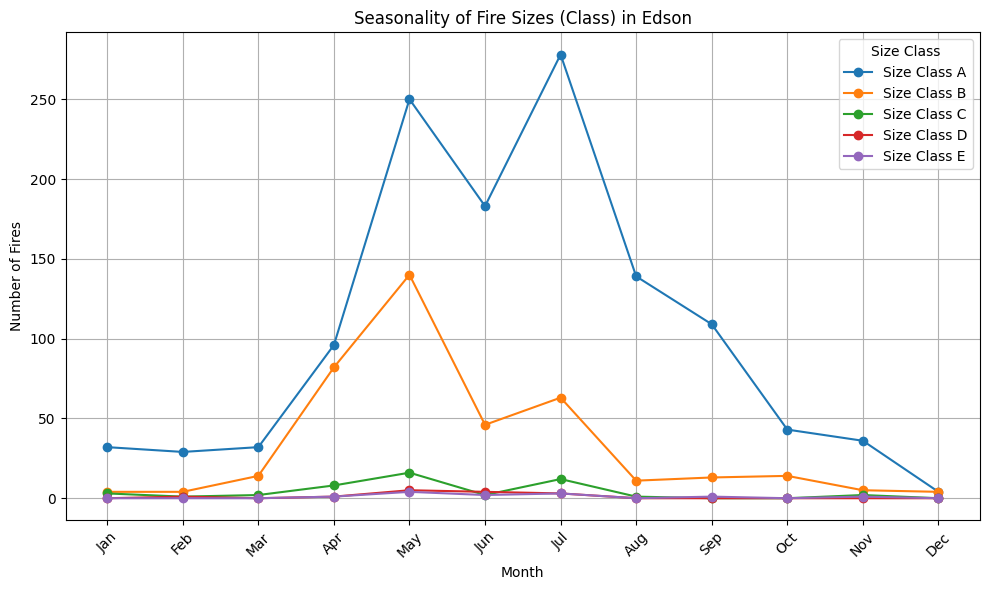

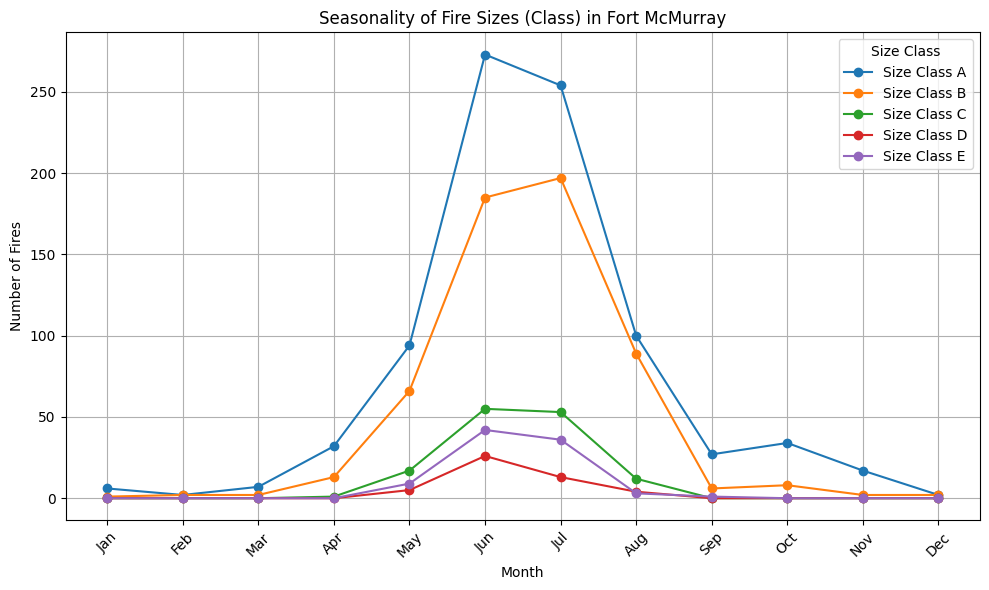

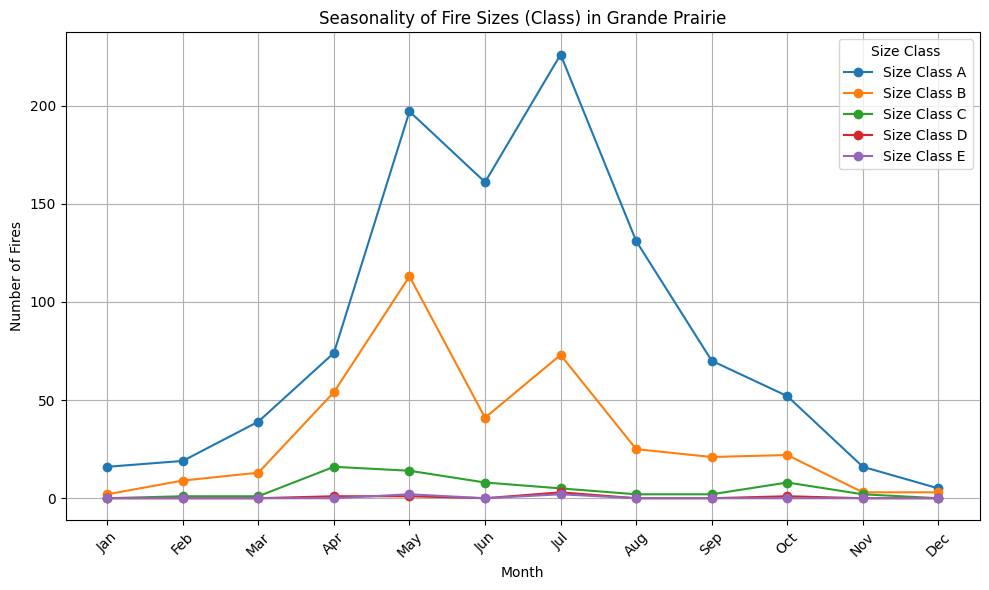

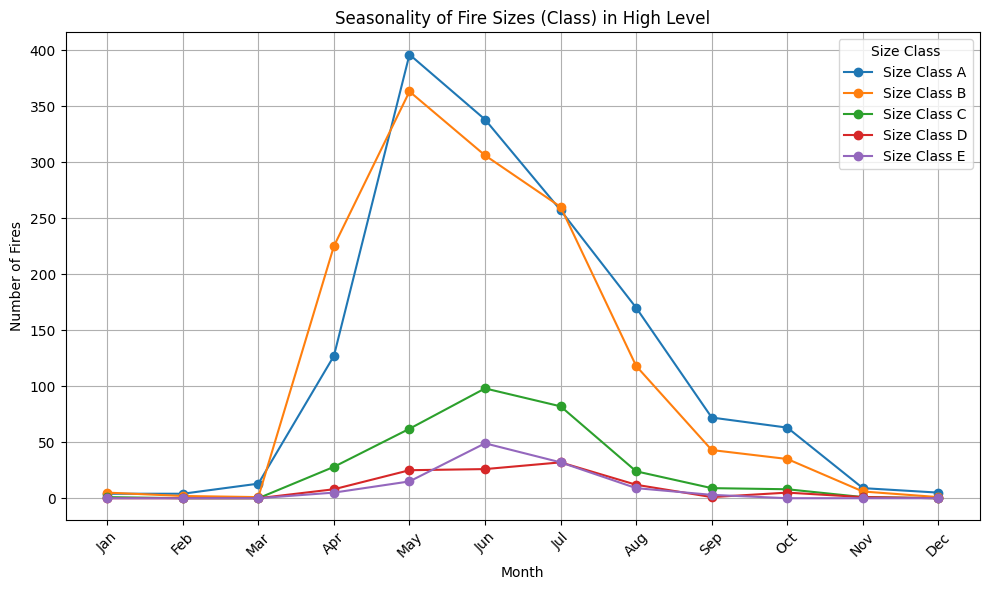

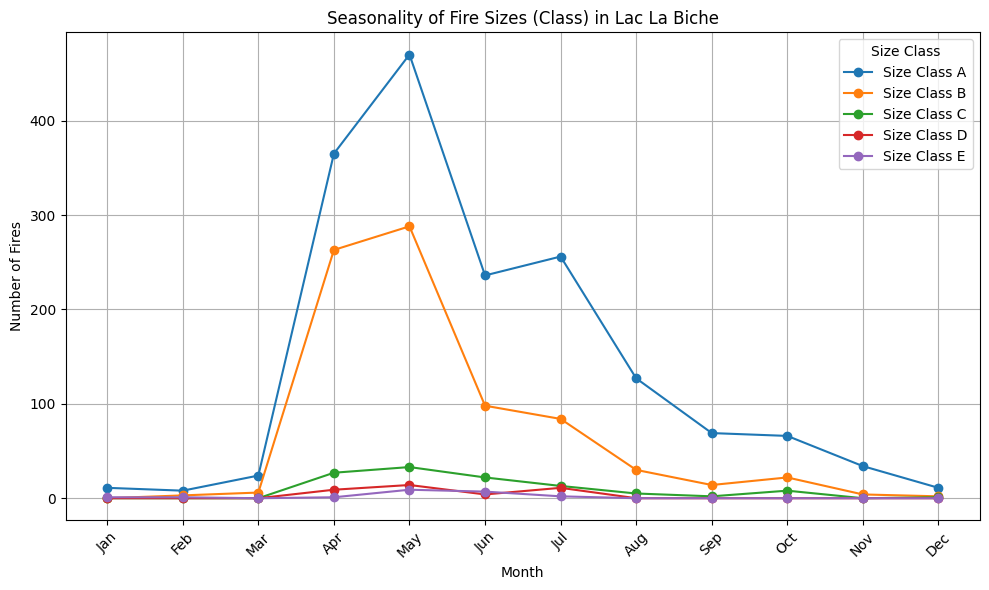

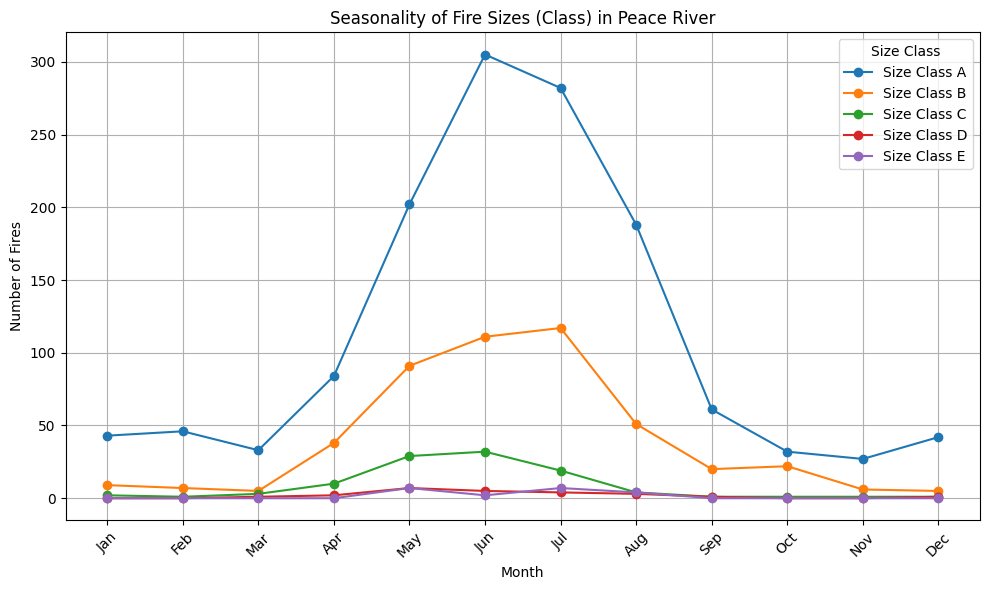

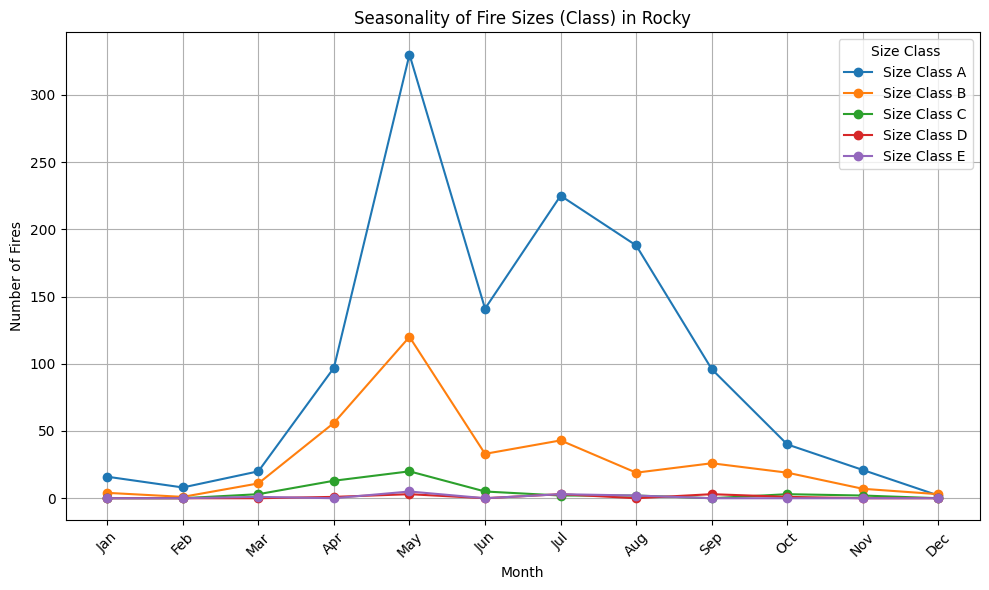

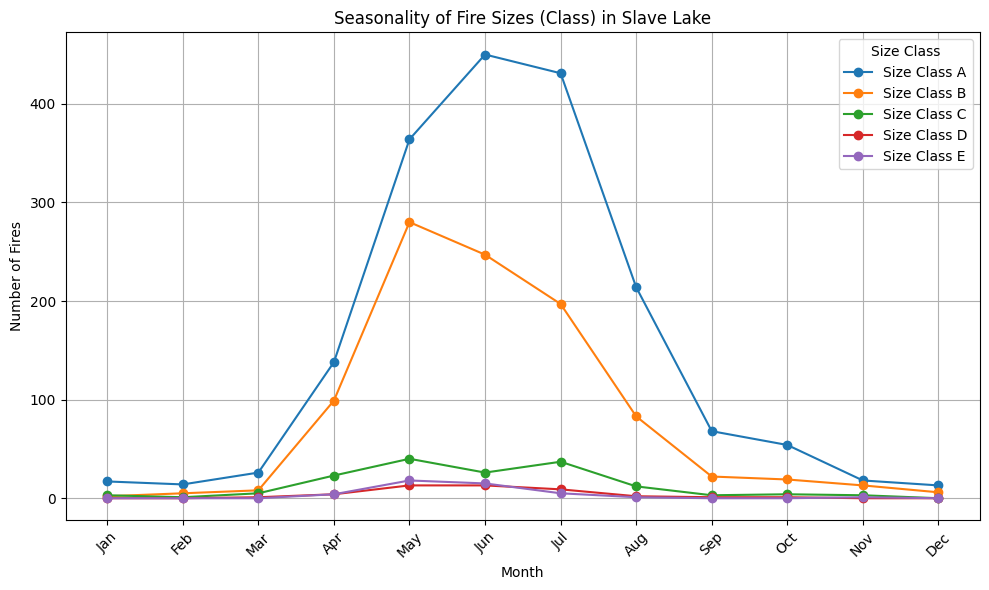

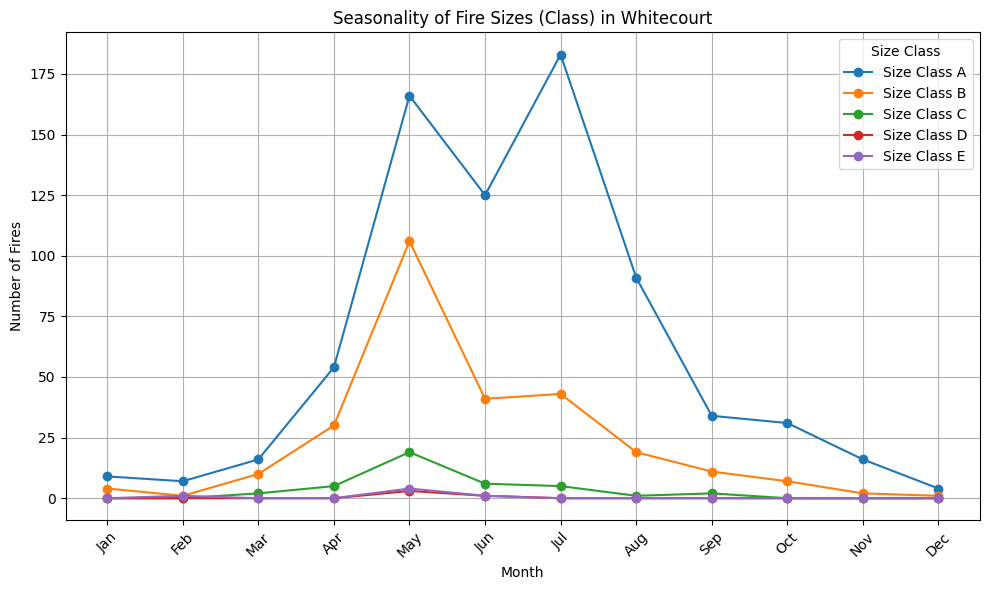

In [ ]:
monthly_class_data = df_copy.groupby(['forest_area_name', 'month', 'size_class']).size().reset_index(name='count')

pivot_data = monthly_class_data.pivot_table(index=['forest_area_name', 'month'],
                                                columns='size_class',
                                                values='count',
                                                fill_value=0).reset_index()

# Ensure 'fsa_regions' contains the correct list of unique FSA regions

fsa_regions = pivot_data['forest_area_name'].unique()

months = range(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop through each forest area name
for region in fsa_regions:
    # Filter data for the current region
    region_data = pivot_data[pivot_data['forest_area_name'] == region]

    # Start a new figure for each region
    plt.figure(figsize=(10, 6))

    # Plot each size class for the region
    for size_class in ['A', 'B', 'C', 'D', 'E']:
        # Extract the monthly count for each size class
        monthly_counts = region_data.loc[region_data['forest_area_name'] == region, size_class].values
        plt.plot(months, monthly_counts, marker='o', label=f'Size Class {size_class}')

    plt.title(f'Seasonality of Fire Sizes (Class) in {region}')
    plt.xlabel('Month')
    plt.ylabel('Number of Fires')
    plt.legend(title='Size Class')
    plt.xticks(ticks=months, labels=month_labels, rotation=45)  # Set custom month labels
    plt.grid(True)

    plt.tight_layout()
    # Optionally save each figure with a unique name
    plt.savefig(f'fire_seasonality_{region}.png')

    plt.show()  # Show the plot


# Efficiency of the response by firefighting source

# FIRE GROWTH

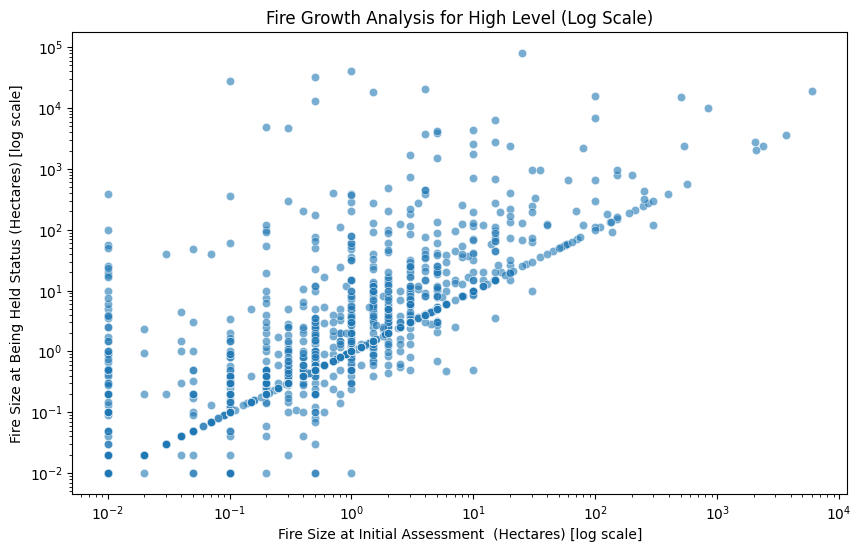

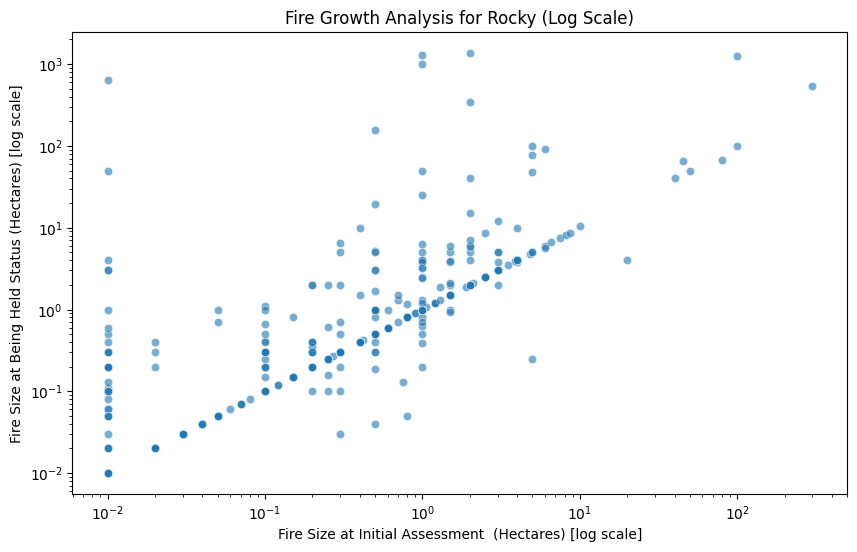

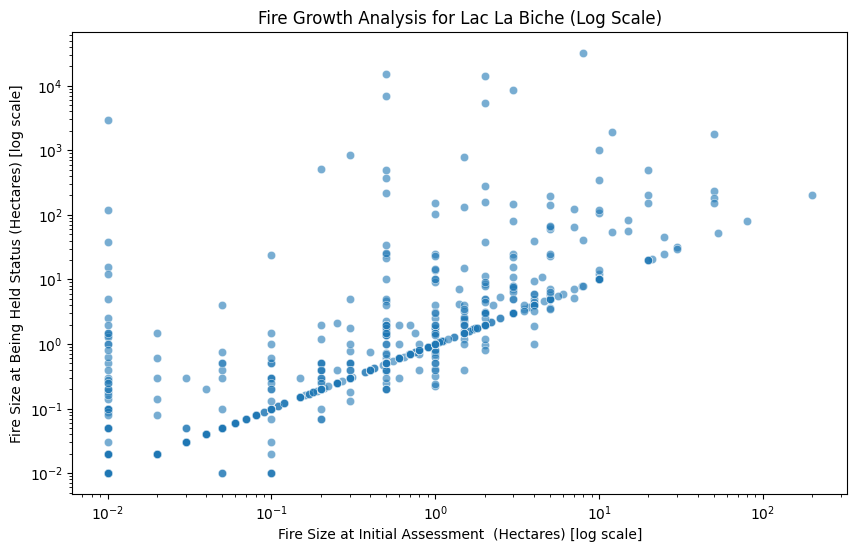

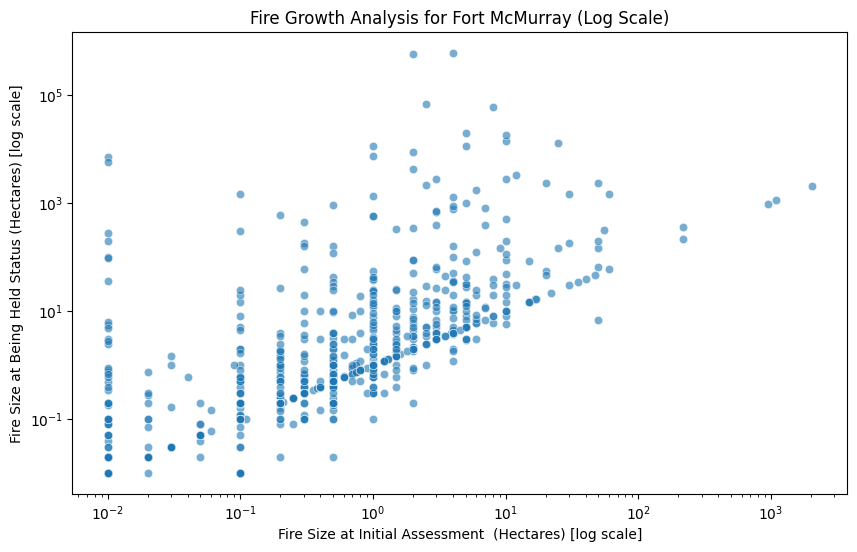

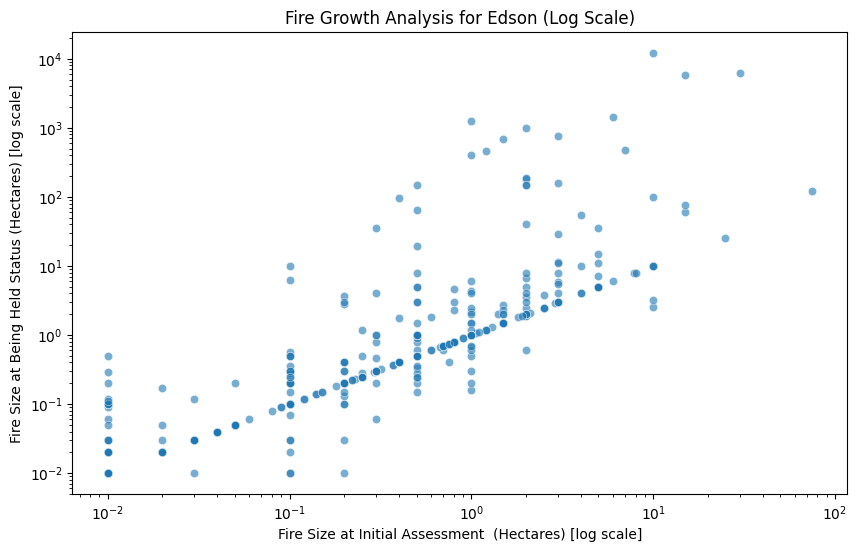

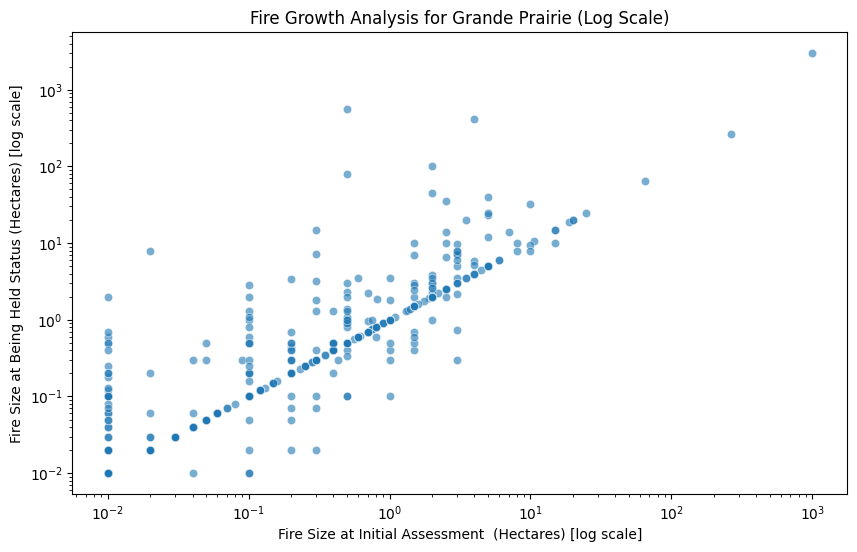

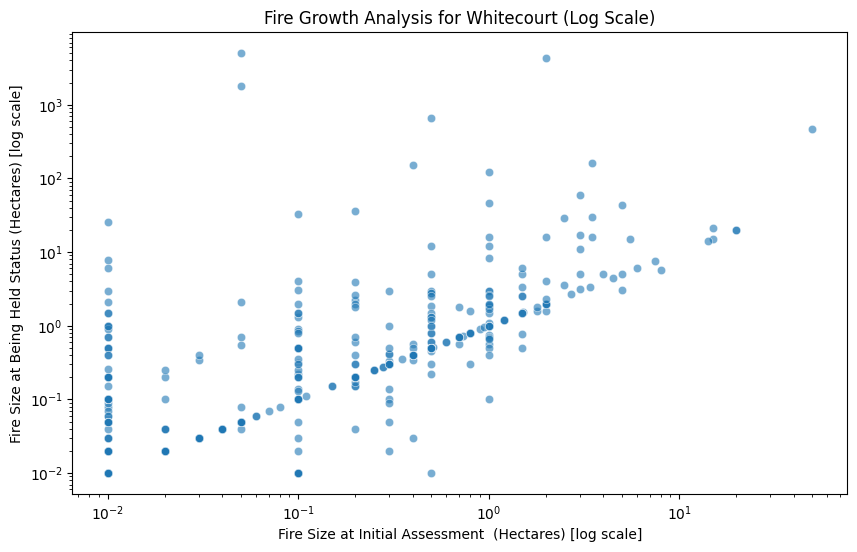

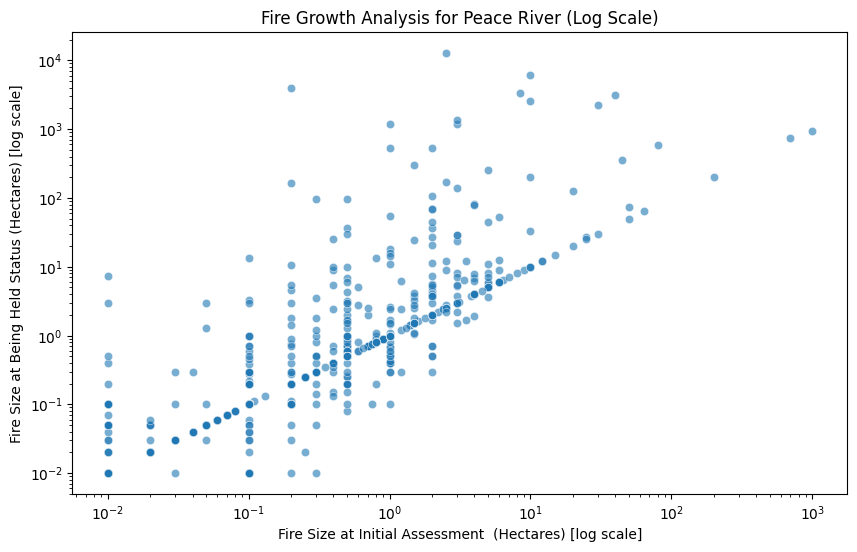

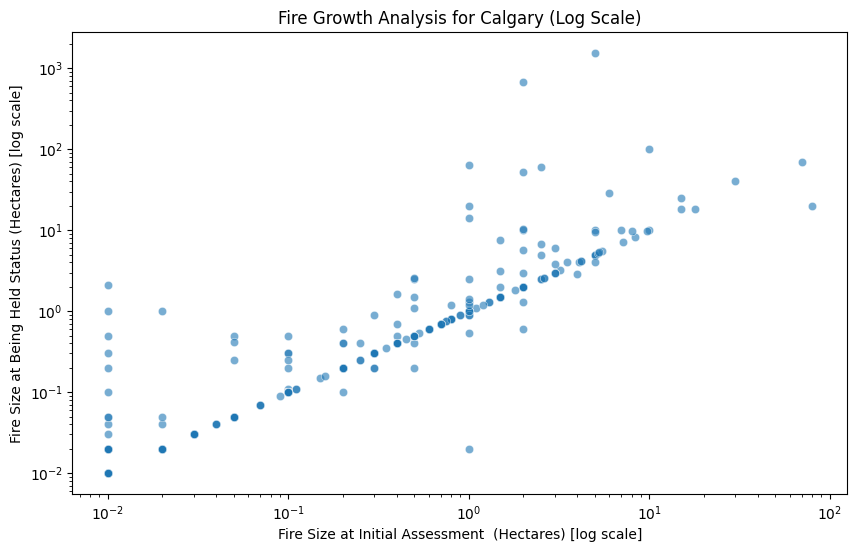

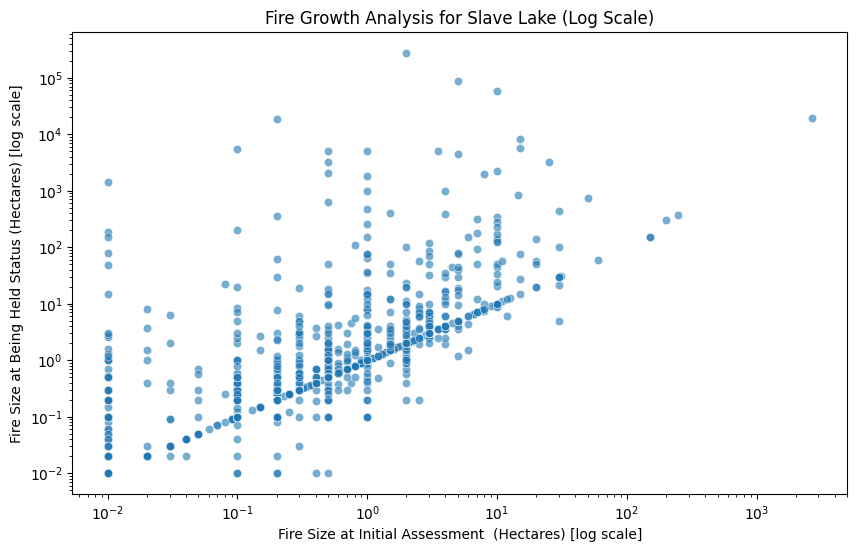

In [ ]:
df_copy['area_code'] = df_copy['fire_number'].str[0]

forest_area_names = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}
df_copy['city'] = df_copy['area_code'].map(forest_area_names)

cities = df_copy['city'].unique()

# Loop through each city to generate separate scatter plots
for city in cities:
    # Filter the dataframe for the current city
    city_data = df_copy[df_copy['city'] == city]

    # Create the scatter plot for the current city
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=city_data, x='assessment_hectares', y='bh_hectares', alpha=0.6)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Fire Growth Analysis for {city} (Log Scale)')
    plt.xlabel('Fire Size at Initial Assessment  (Hectares) [log scale]')
    plt.ylabel('Fire Size at Being Held Status (Hectares) [log scale]')

    # Show the plot
    plt.show()

# Time to Control

<ipython-input-16-644f48e1dee1>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped_data.pivot("city", "assessment_resource", "duration_hours")


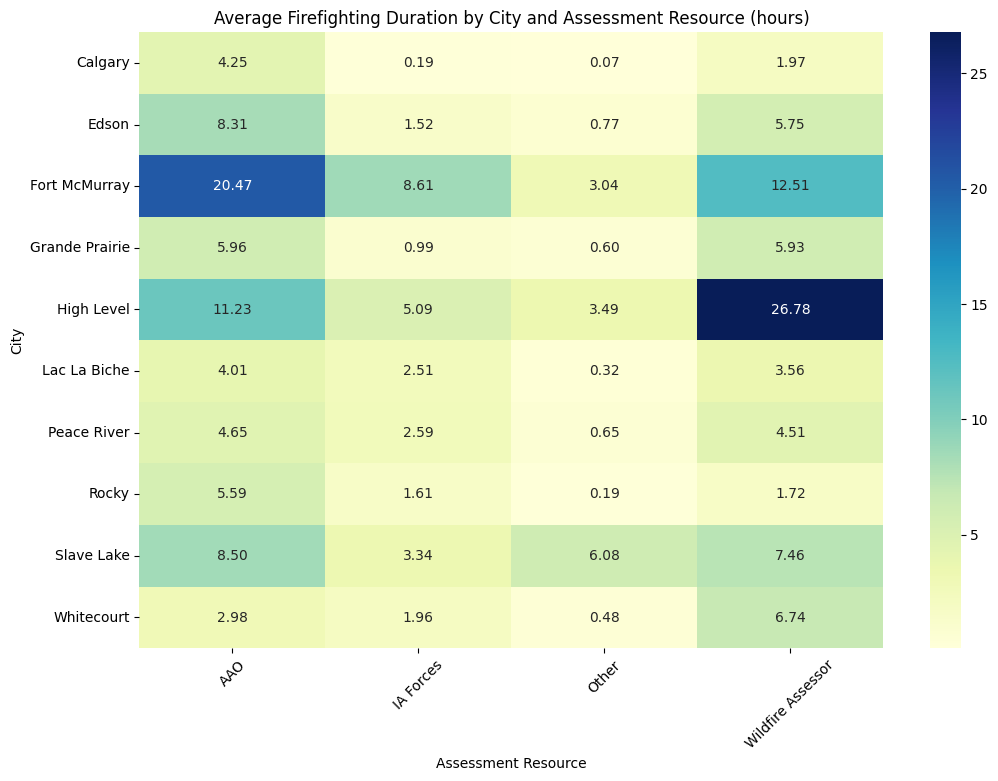

In [ ]:
# Convert date strings to datetime
df_copy['assessment_datetime'] = pd.to_datetime(df_copy['assessment_datetime'])
df_copy['bh_fs_date'] = pd.to_datetime(df_copy['bh_fs_date'])

# Calculate the duration in hours
df_copy['duration_hours'] = (df_copy['bh_fs_date'] - df_copy['assessment_datetime']).dt.total_seconds() / 3600
df_copy['duration_hours']

# Group by 'city' and 'assessment_resources' and calculate the mean duration
grouped_data = df_copy.groupby(['city', 'assessment_resource'])['duration_hours'].mean().reset_index()
grouped_data

# Pivot data for heatmap
pivot_table = grouped_data.pivot("city", "assessment_resource", "duration_hours")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Average Firefighting Duration by City and Assessment Resource (hours)')
plt.ylabel('City')
plt.xlabel('Assessment Resource')
plt.xticks(rotation=45)
plt.show()

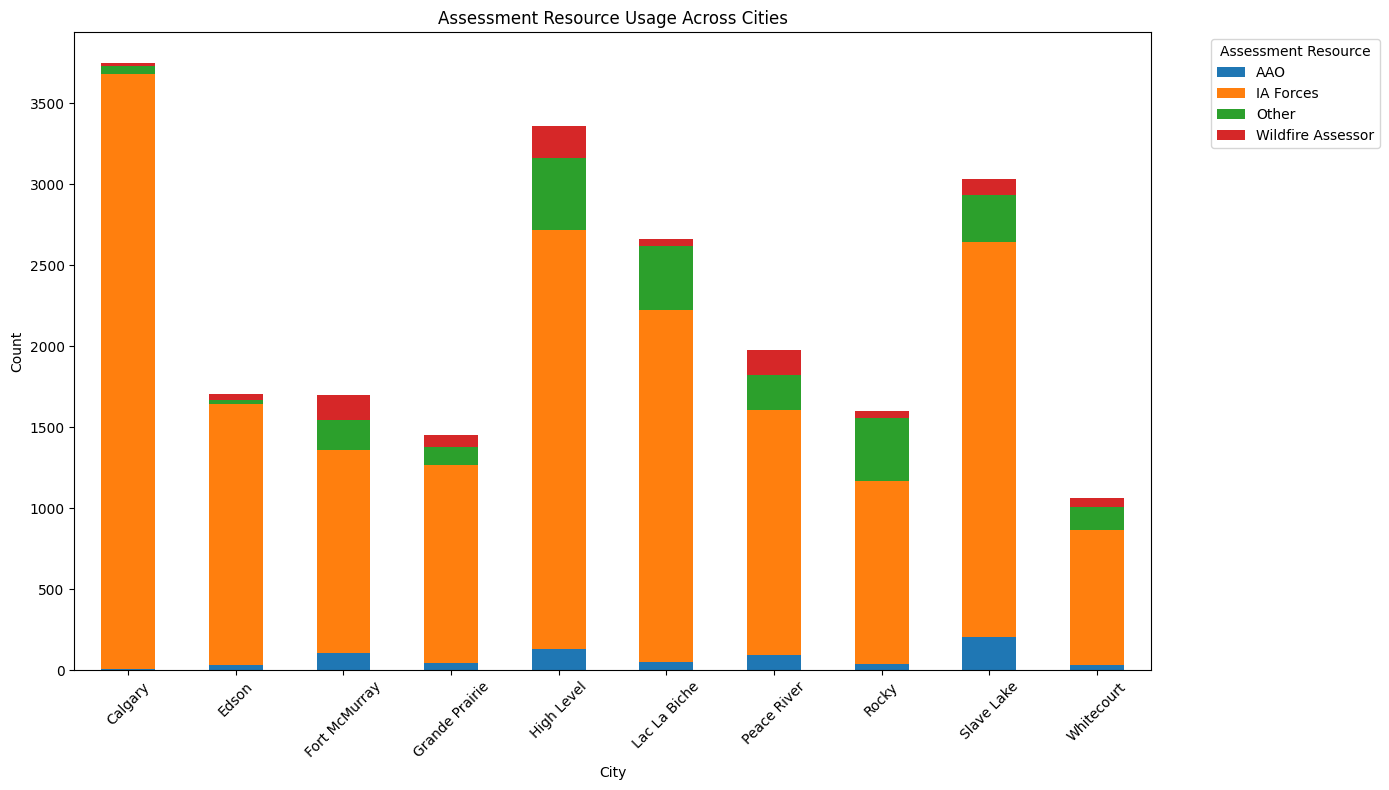

In [ ]:
resource_counts = df_copy.groupby(['city', 'assessment_resource']).size().reset_index(name='counts')

# Pivot the data to get cities on the rows and assessment resources on the columns with counts as values
pivot_table = resource_counts.pivot(index='city', columns='assessment_resource', values='counts').fillna(0)

# Plot
pivot_table.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Assessment Resource Usage Across Cities')
plt.ylabel('Count')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.legend(title='Assessment Resource', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Resource to Control Effectiveness

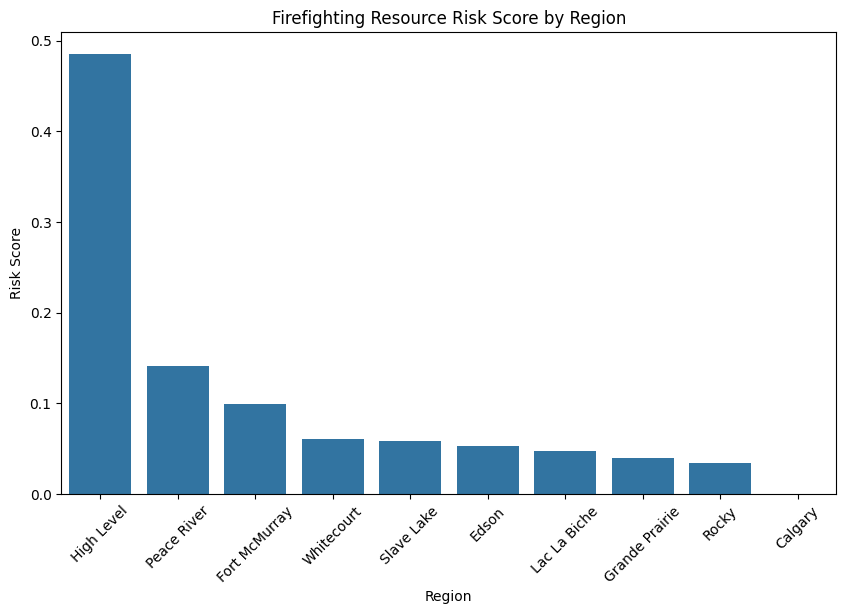

In [ ]:
# number of resources in each region
resources_data = {
    'city': ['Calgary', 'Edson', 'Fort McMurray', 'Grande Prairie', 'High Level', 'Lac La Biche', 'Peace River', 'Rocky', 'Slave Lake', 'Whitecourt'],
    'num_firefighters': [1561, 40, 130, 68, 30, 62, 30, 60, 100, 40],
}

df_resources = pd.DataFrame(resources_data)

wildfire_metrics = df_copy.groupby('city').agg(
    num_fires=('fire_number', 'count'),
    avg_fire_size=('assessment_hectares', 'mean'),
    avg_control_time=('duration_hours', 'mean')
).reset_index()

# Merge resources data with wildfire metrics
analysis_df = pd.merge(df_resources, wildfire_metrics, on='city', how='left')
analysis_df['risk_score'] = (analysis_df['avg_fire_size'] + analysis_df['avg_control_time']) / (analysis_df['num_firefighters'])

# Sort regions by risk score, higher scores could indicate higher risk
risk_regions = analysis_df.sort_values(by='risk_score', ascending=False)

# Plotting risk score by city
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='risk_score', data=risk_regions)
plt.xticks(rotation=45)
plt.title('Firefighting Resource Risk Score by Region')
plt.ylabel('Risk Score')
plt.xlabel('Region')
plt.show()






# Indigeneous Data

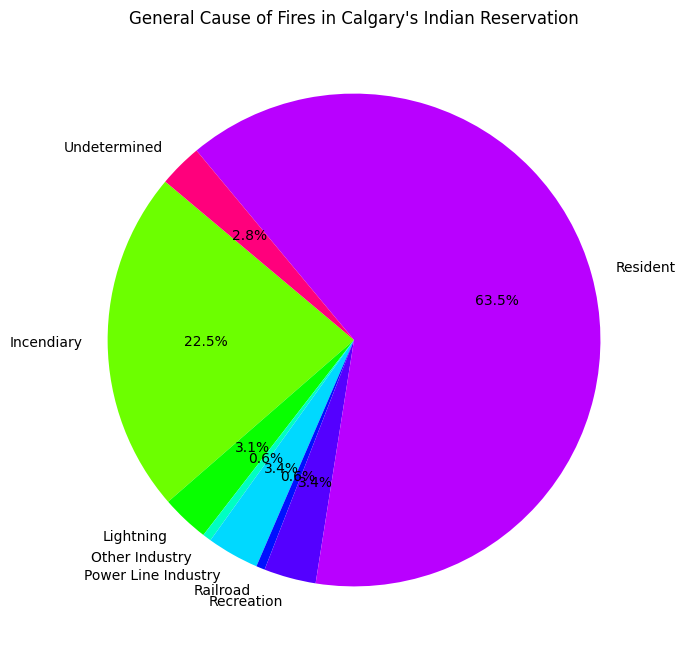

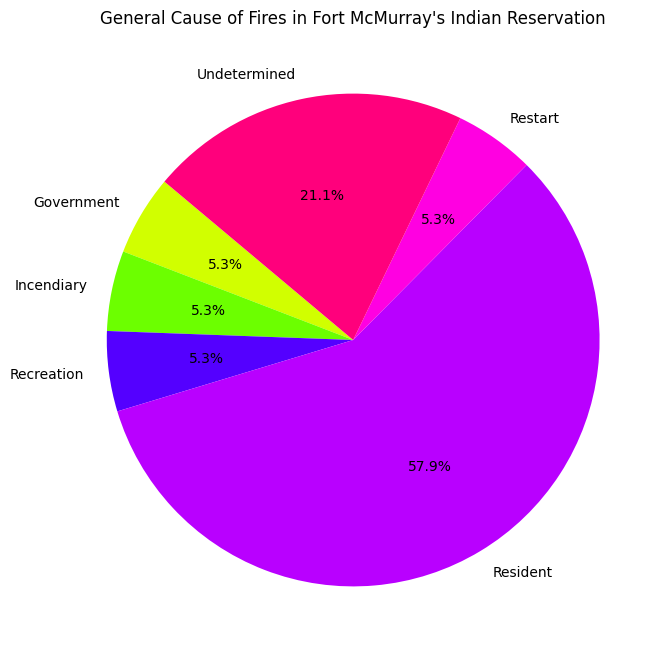

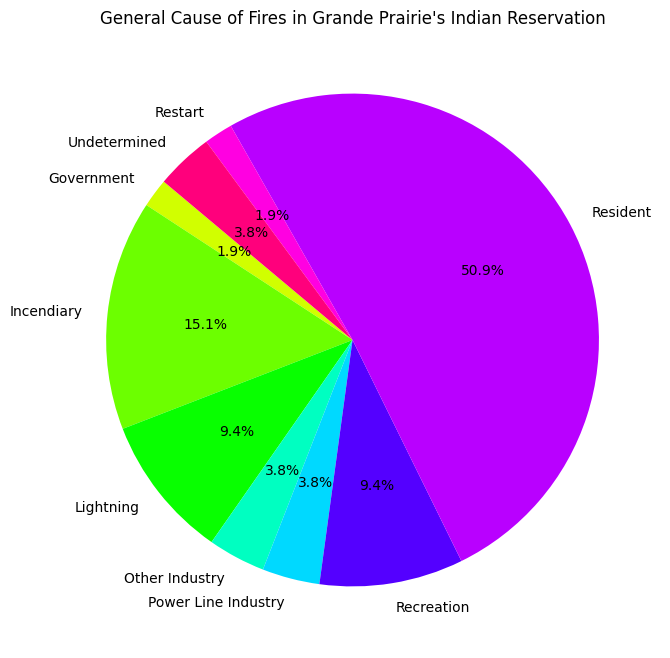

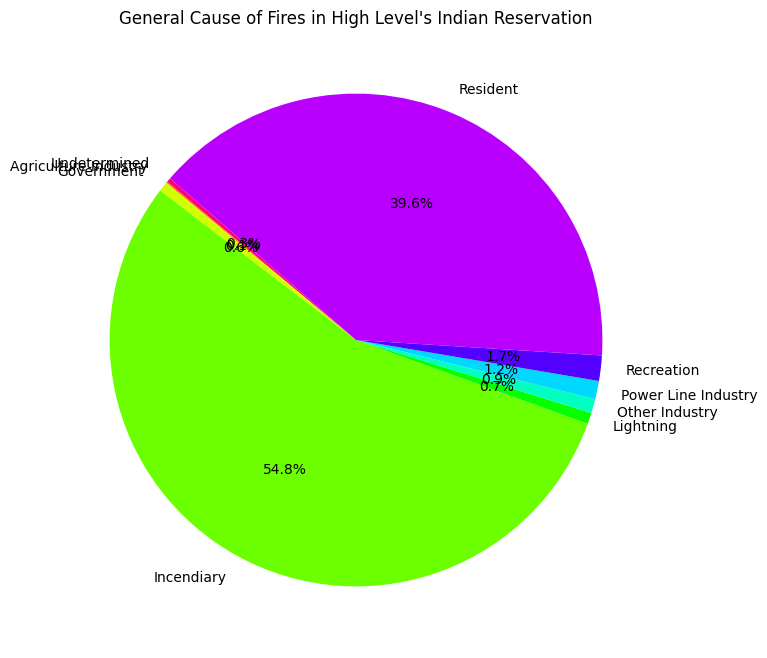

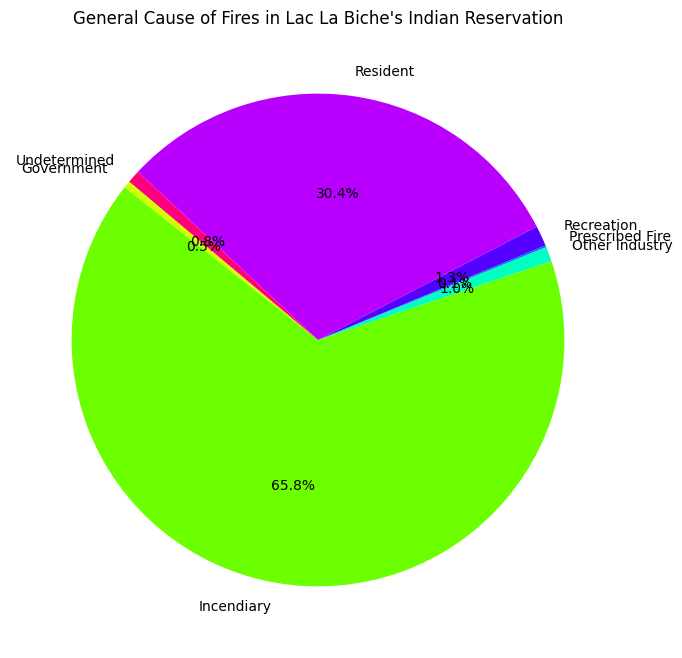

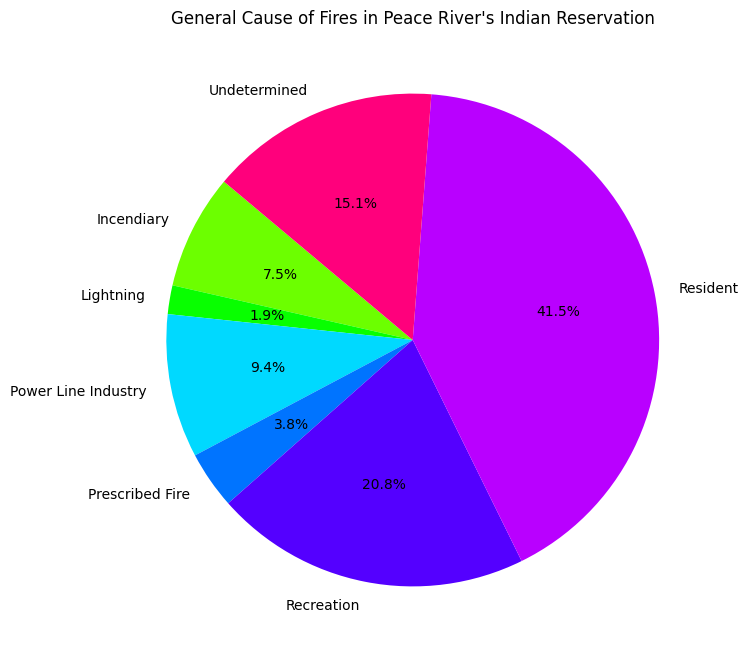

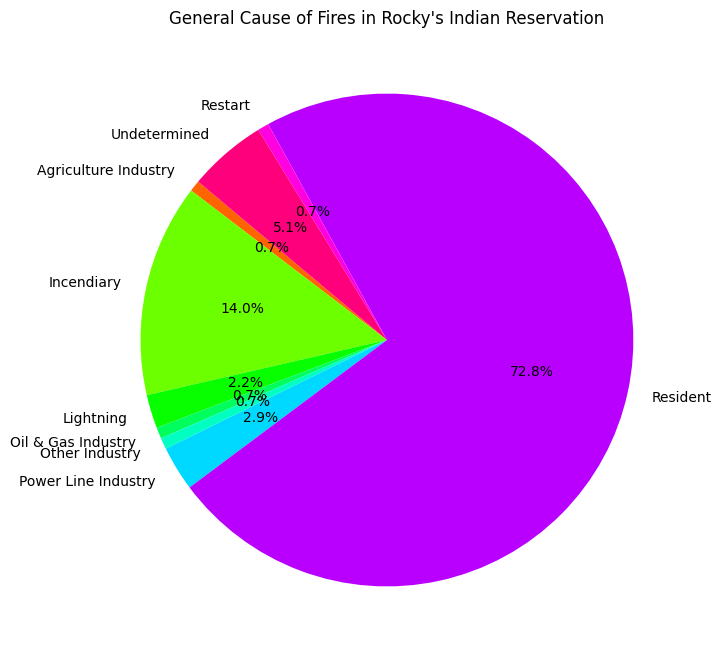

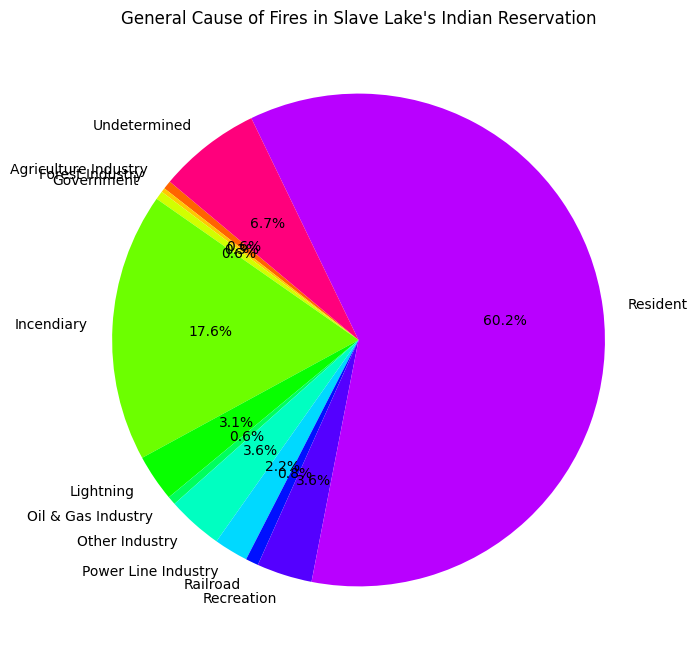

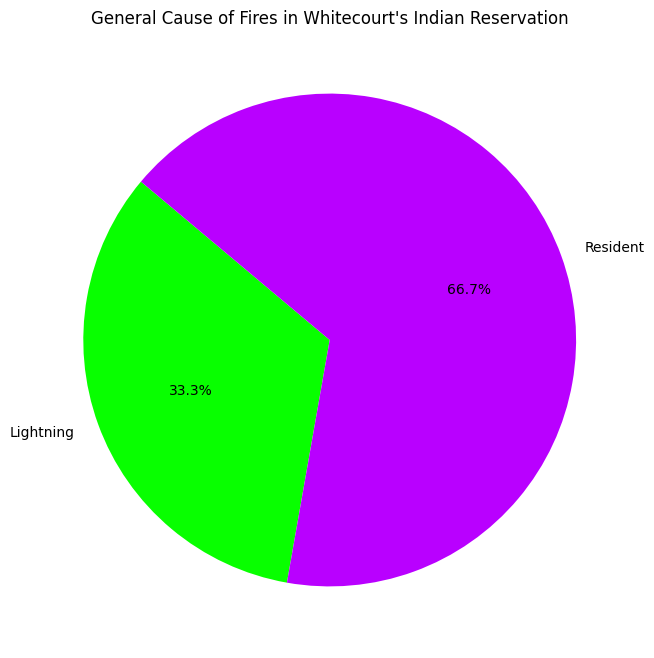

In [ ]:
df_copy2 = df_og.copy()

df_copy2['area_code'] = df_copy2['fire_number'].str[0]

forest_area_names = {
    'C': 'Calgary',
    'E': 'Edson',
    'H': 'High Level',
    'G': 'Grande Prairie',
    'L': 'Lac La Biche',
    'M': 'Fort McMurray',
    'P': 'Peace River',
    'R': 'Rocky',
    'S': 'Slave Lake',
    'W': 'Whitecourt'
}
df_copy2['city'] = df_copy2['area_code'].map(forest_area_names)

df_ID = df_copy2[df_copy2['fire_origin'] == 'Indian Reservation']

fires_per_city = df_ID['city'].value_counts()
fires_per_city

cause_counts = df_ID.groupby(['city', 'general_cause_desc']).size().unstack(fill_value=0)

all_causes = cause_counts.columns.tolist()

# Generate a color palette with a unique color for each cause
palette = sns.color_palette("hsv", len(all_causes))
color_map = {cause: color for cause, color in zip(all_causes, palette)}

for city in cause_counts.index:
    # Select data for the city
    data = cause_counts.loc[city]
    # Filter out causes with 0 occurrences to avoid clutter
    data = data[data > 0]

    # Create a list of colors for the existing causes in this city
    pie_colors = [color_map[cause] for cause in data.index if cause in color_map]

    # Generate the pie chart for the city
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=pie_colors)
    plt.title(f'General Cause of Fires in {city}\'s Indian Reservation')

    # Show the plot
    plt.show()

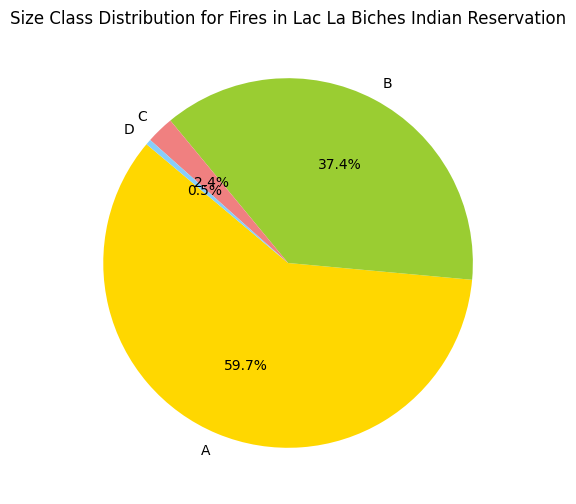

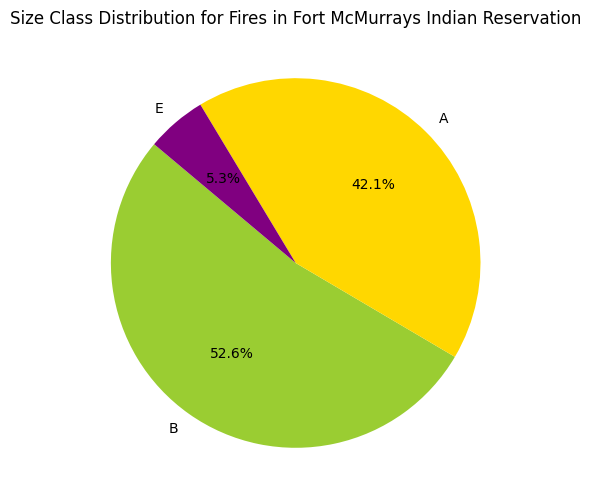

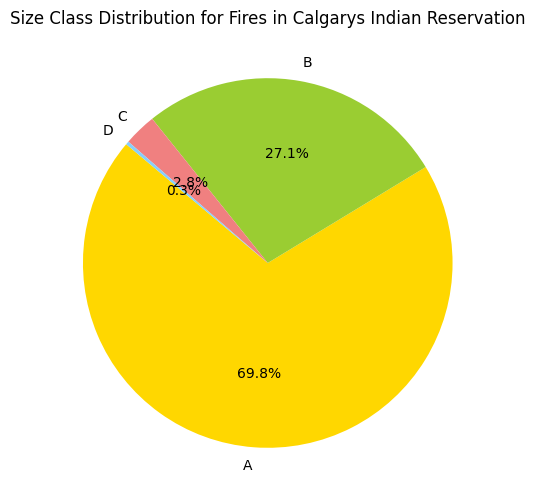

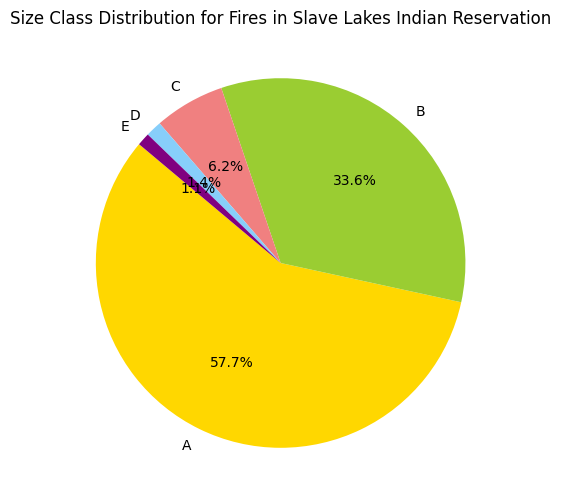

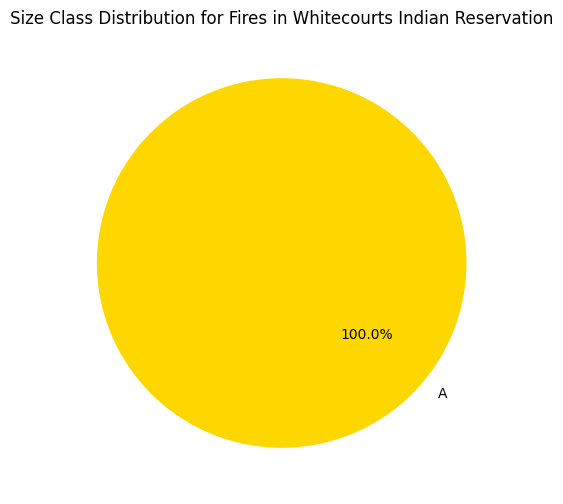

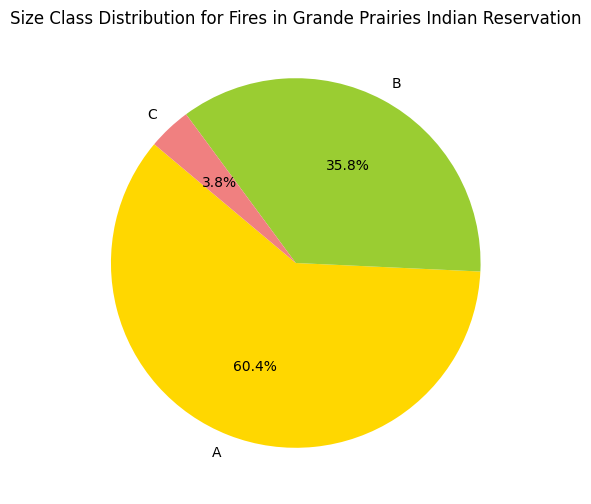

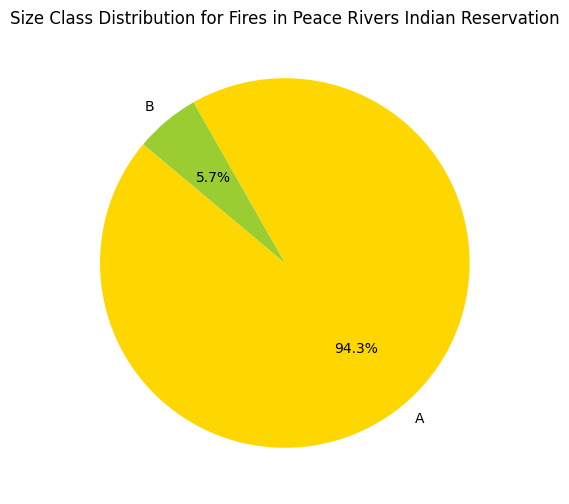

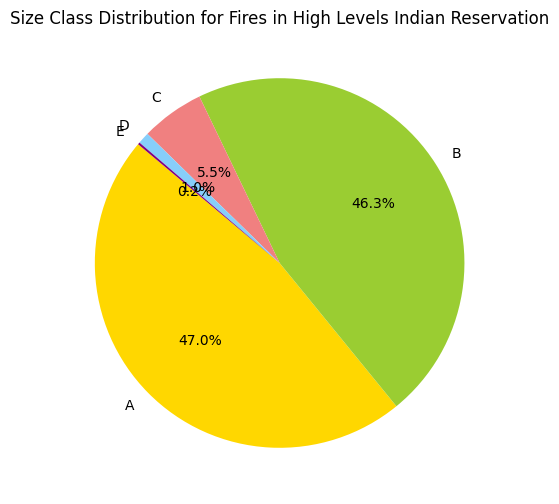

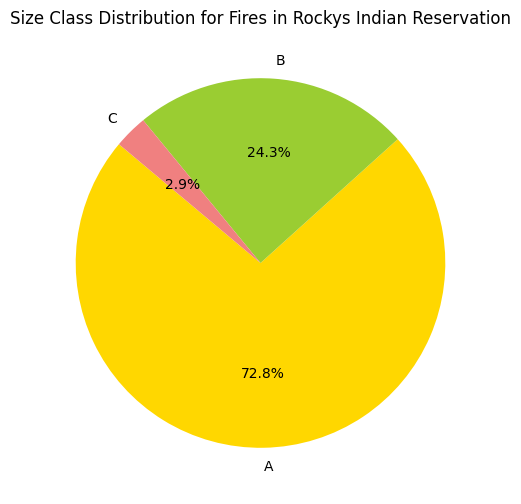

In [ ]:
colors = {
    'A': 'gold',
    'B': 'yellowgreen',
    'C': 'lightcoral',
    'D': 'lightskyblue',
    'E': 'purple'
}

cities = df_ID['city'].unique()

for city in cities:
    city_data = df_ID[df_ID['city'] == city]
    size_class_counts = city_data['size_class'].value_counts(normalize=True) * 100  # Normalize to get percentage

    if not size_class_counts.empty:
        # Order size_class_counts by size class to ensure color consistency
        ordered_counts = size_class_counts.loc[['A', 'B', 'C', 'D', 'E']] if all(x in size_class_counts.index for x in ['A', 'B', 'C', 'D', 'E']) else size_class_counts

        # Get colors in the order of size classes
        colors_list = [colors[size_class] for size_class in ordered_counts.index if size_class in colors]

        plt.figure(figsize=(6, 6))
        plt.pie(ordered_counts, labels=ordered_counts.index, autopct='%1.1f%%', startangle=140, colors=colors_list)
        plt.title(f'Size Class Distribution for Fires in {city}s Indian Reservation')
        plt.show()

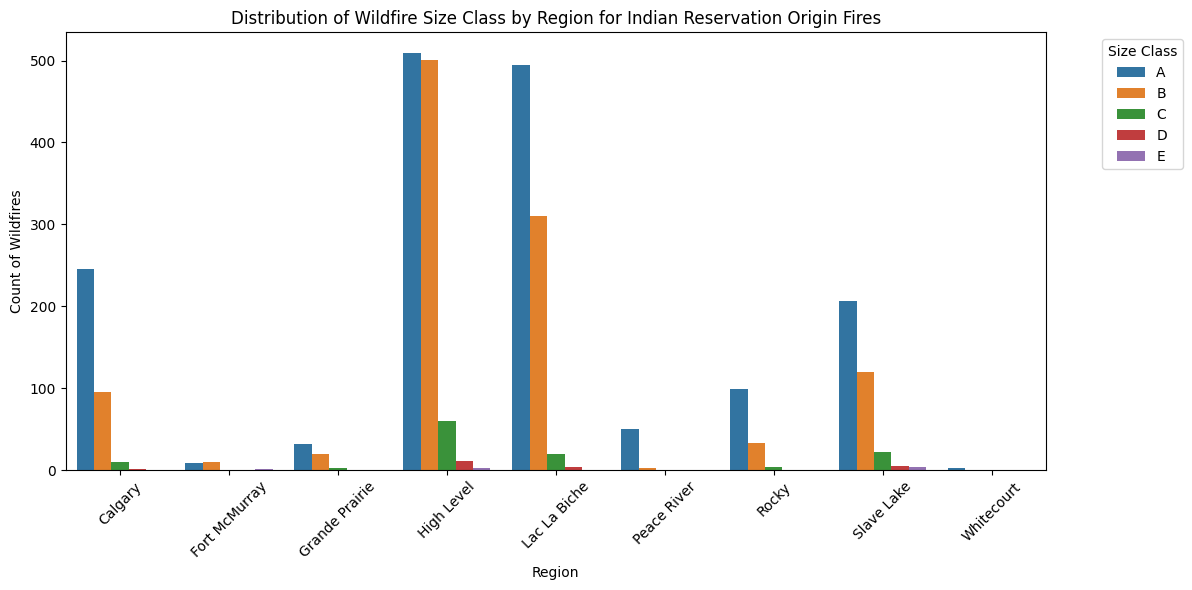

In [ ]:
df_ID = df_og[df_og['fire_origin'] == 'Indian Reservation'].copy()

# Map area codes to names
df_ID['region_name'] = df_ID['fire_number'].str[0].map(forest_area_names)

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(data=df_ID, x='region_name', hue='size_class', order=sorted(df_ID['region_name'].unique()))
plt.title('Distribution of Wildfire Size Class by Region for Indian Reservation Origin Fires')
plt.xlabel('Region')
plt.ylabel('Count of Wildfires')
plt.xticks(rotation=45)
plt.legend(title='Size Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

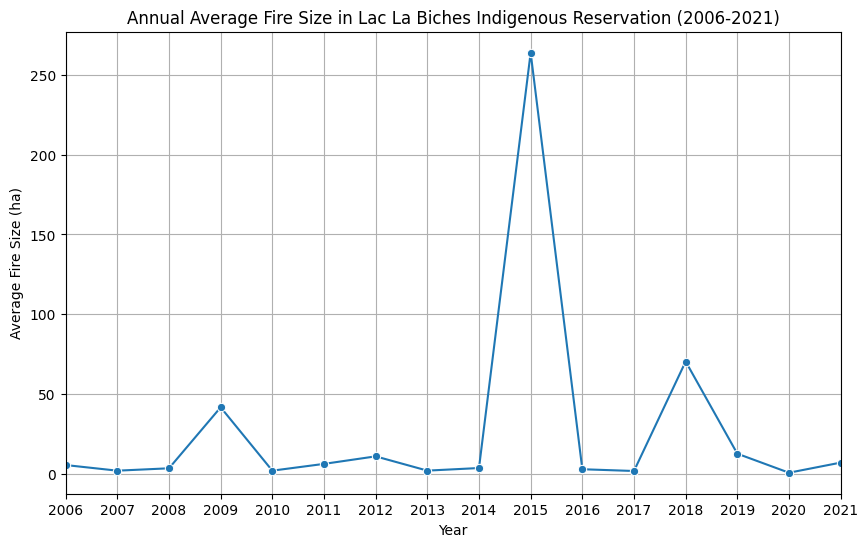

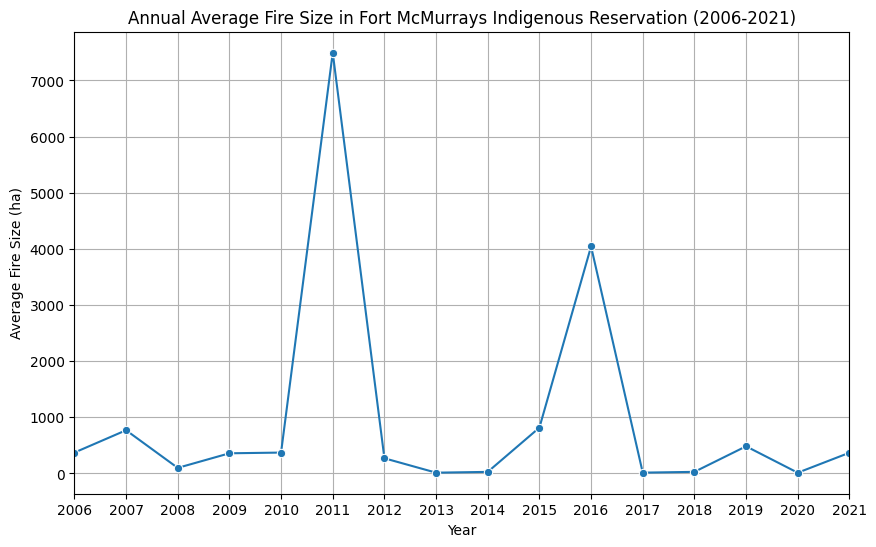

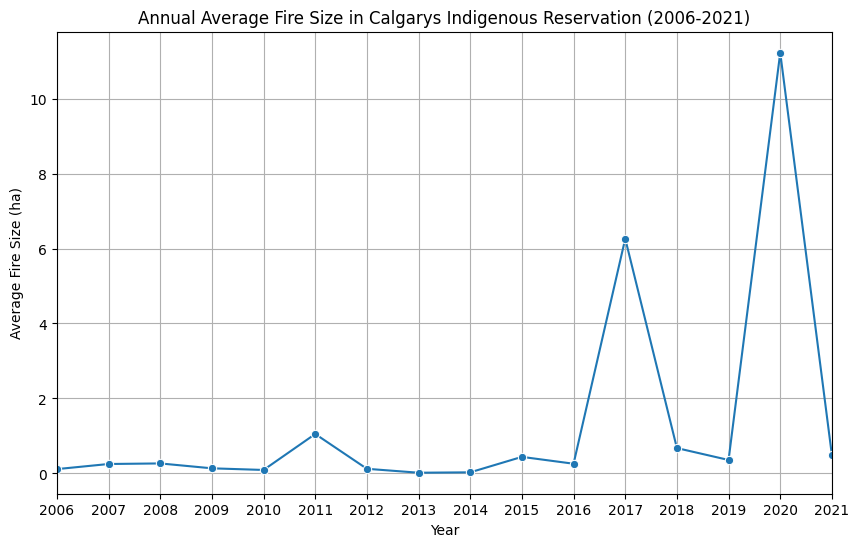

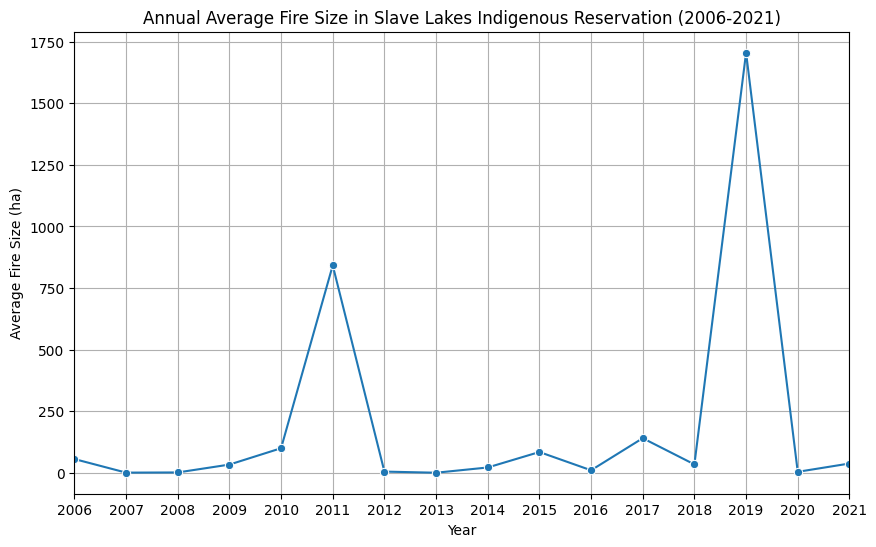

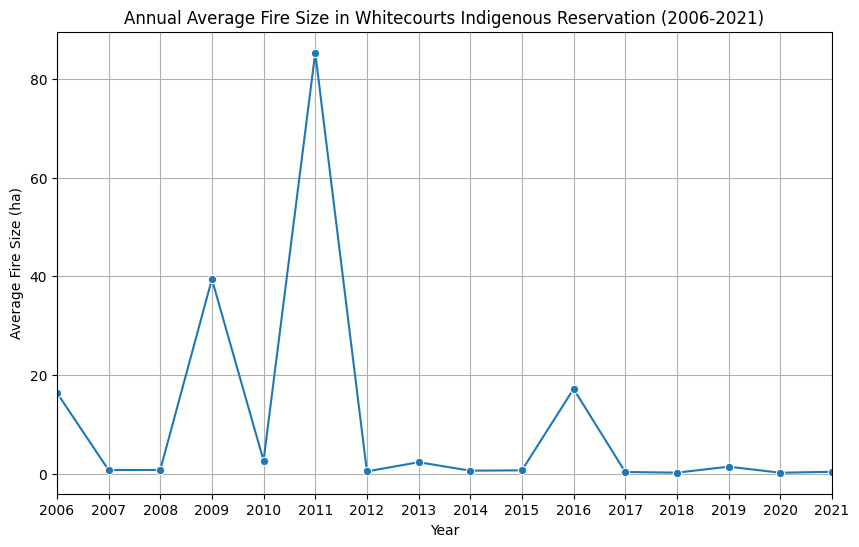

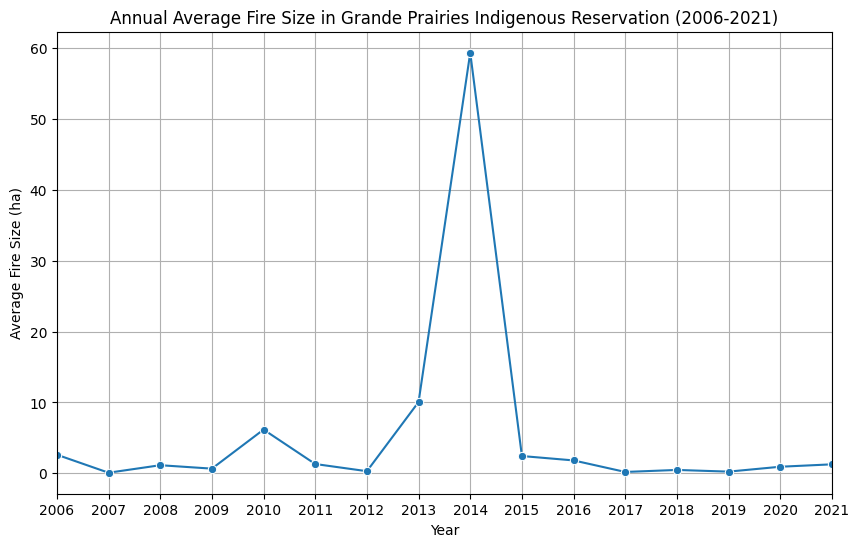

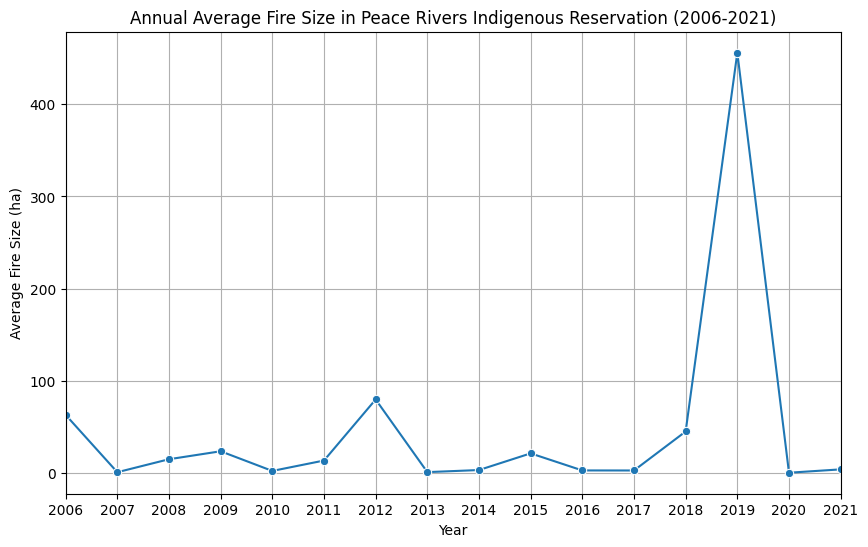

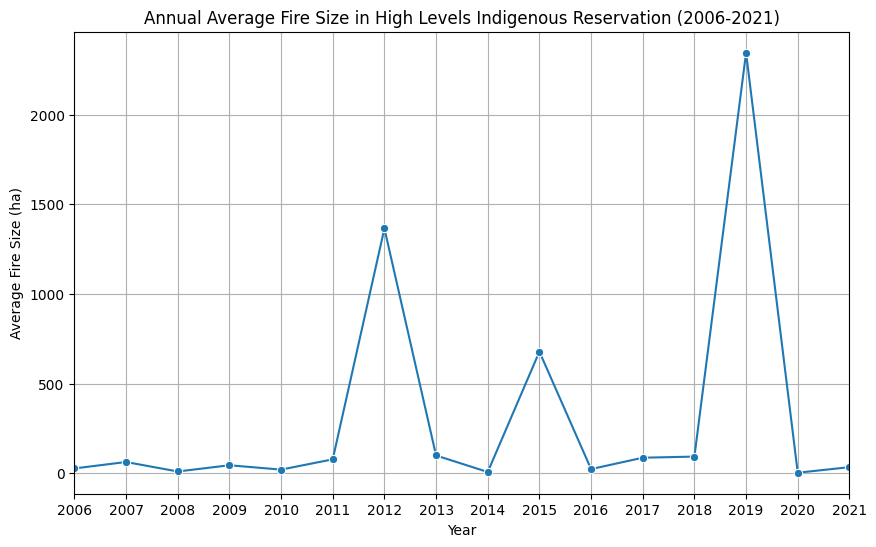

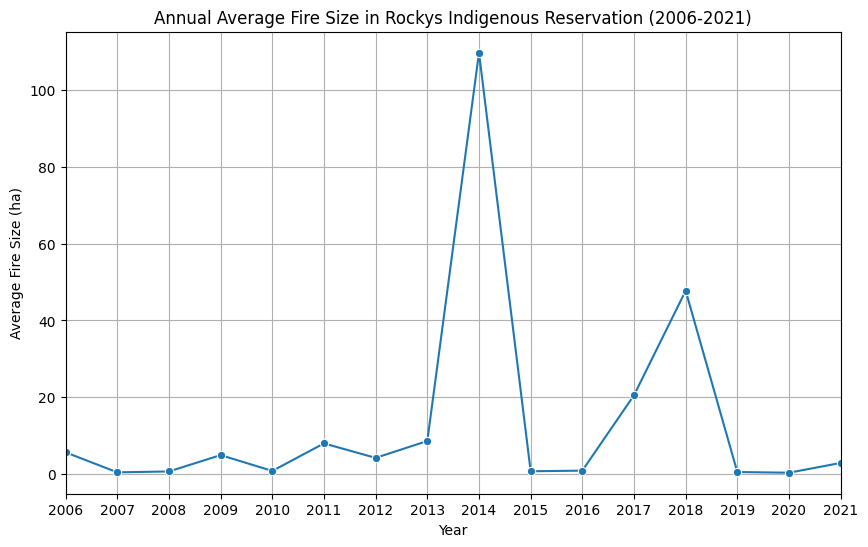

In [ ]:
df_copy2['fire_start_date'] = df_copy2['fire_start_date'].apply(correct_date_string)

df_copy2['region_name'] = df_copy2['fire_number'].str[0].map(forest_area_names)

df_ID2 = df_copy2.copy()

# Group data by region and year to calculate the average fire size
seasonality_data = df_ID2.groupby(['region_name', 'fire_year'])['current_size'].mean().reset_index()

# Plotting
for region_name in df_ID['region_name'].unique():
    # Filter data for the current region
    region_data = seasonality_data[seasonality_data['region_name'] == region_name]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=region_data, x='fire_year', y='current_size', marker='o')

    plt.title(f'Annual Average Fire Size in {region_name}s Indigenous Reservation (2006-2021)')
    plt.xlabel('Year')
    plt.ylabel('Average Fire Size (ha)')
    plt.xlim(2006, 2021)
    plt.xticks(range(2006, 2022))
    plt.grid(True)
    plt.show()

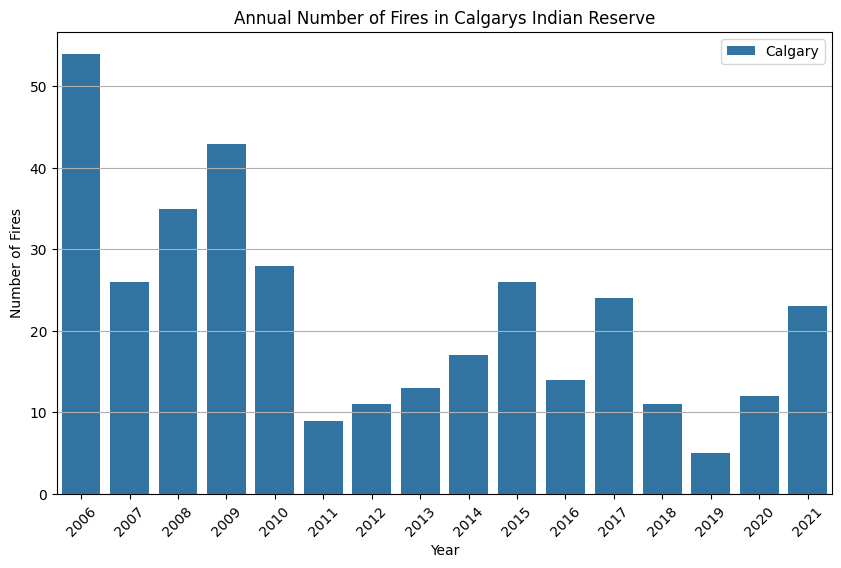

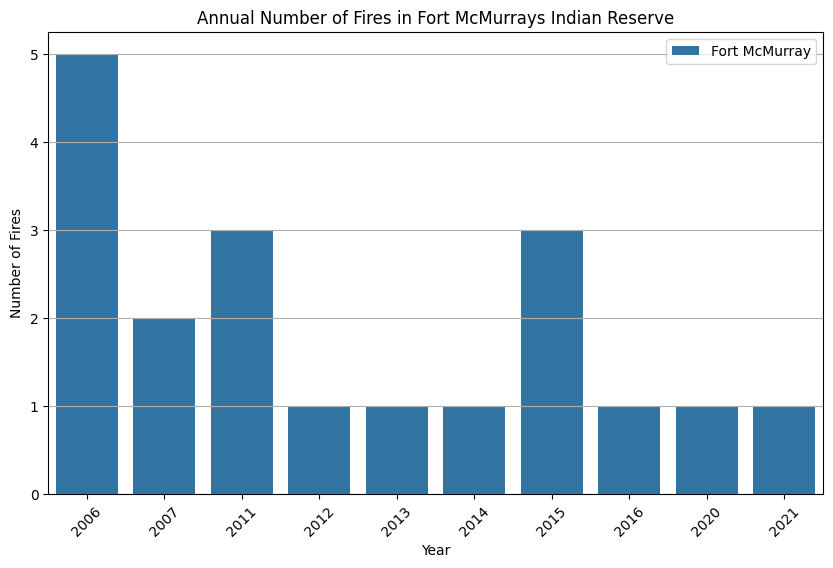

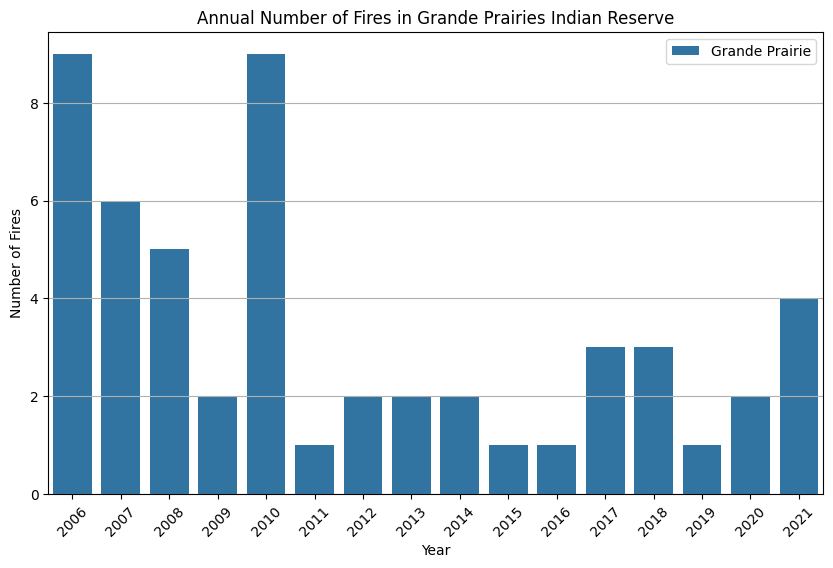

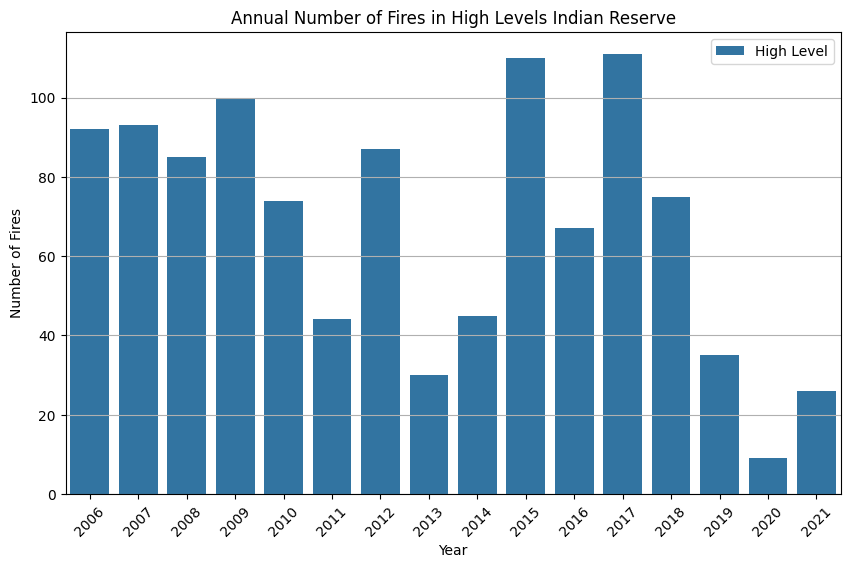

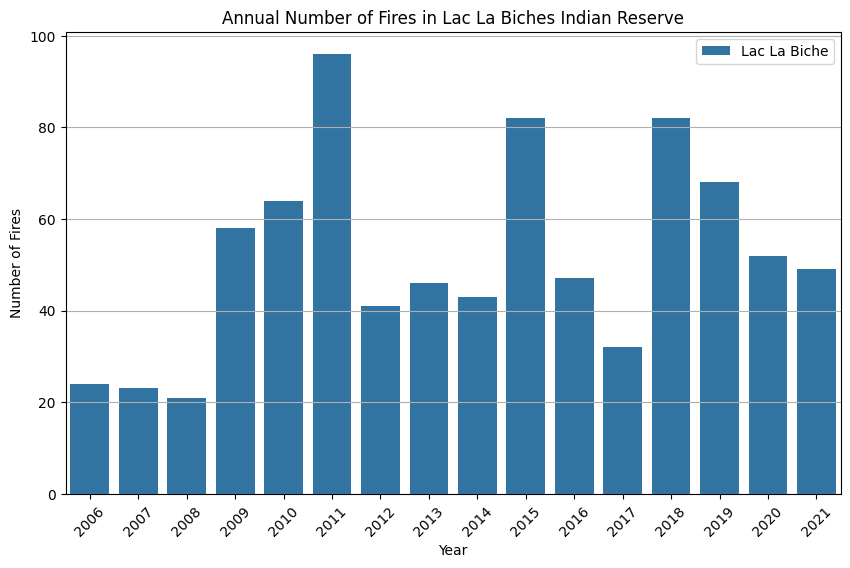

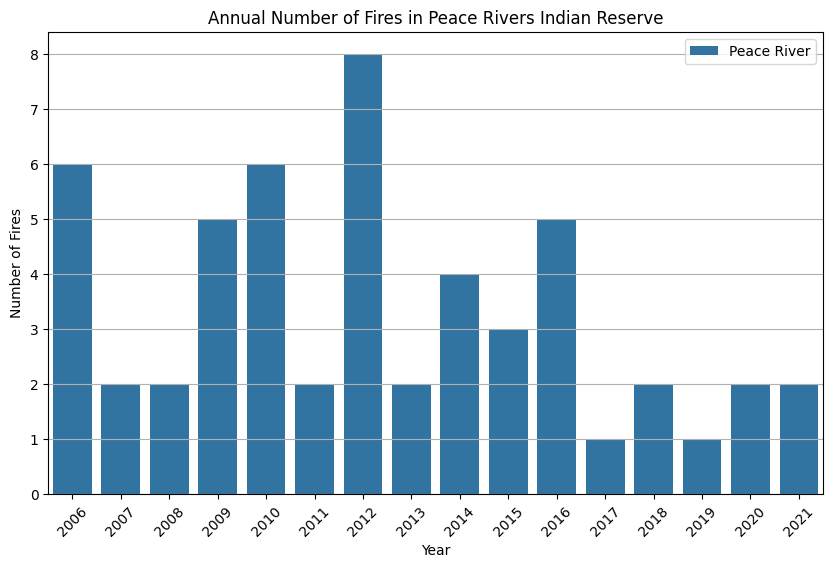

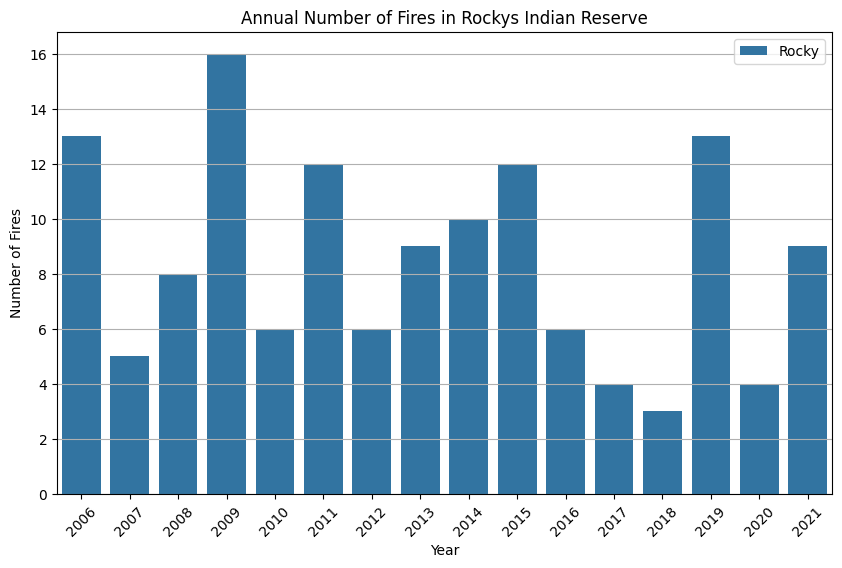

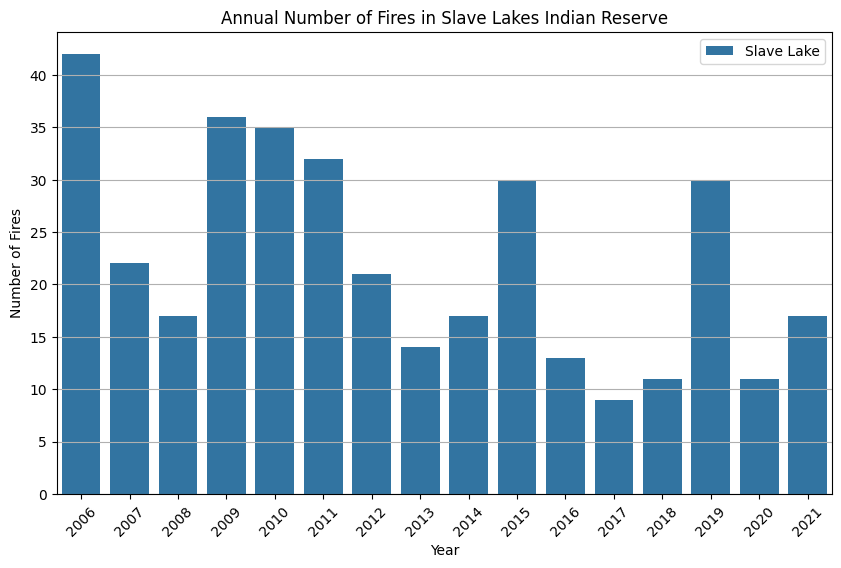

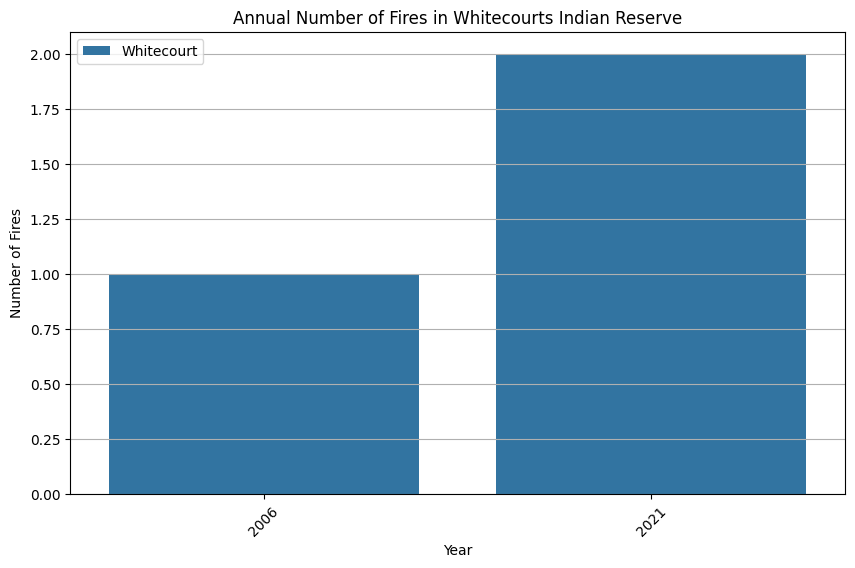

In [ ]:
seasonality_data = df_ID.groupby(['region_name', 'fire_year']).size().reset_index(name='num_fires')

# Plotting
for region_name in seasonality_data['region_name'].unique():
    # Filter data for the current region
    region_data = seasonality_data[seasonality_data['region_name'] == region_name]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=region_data, x='fire_year', y='num_fires', label=region_name)

    plt.title(f'Annual Number of Fires in {region_name}s Indian Reservee')
    plt.xlabel('Year')
    plt.ylabel('Number of Fires')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid(axis='y')  # Add a horizontal grid for easier comparison
    plt.show()

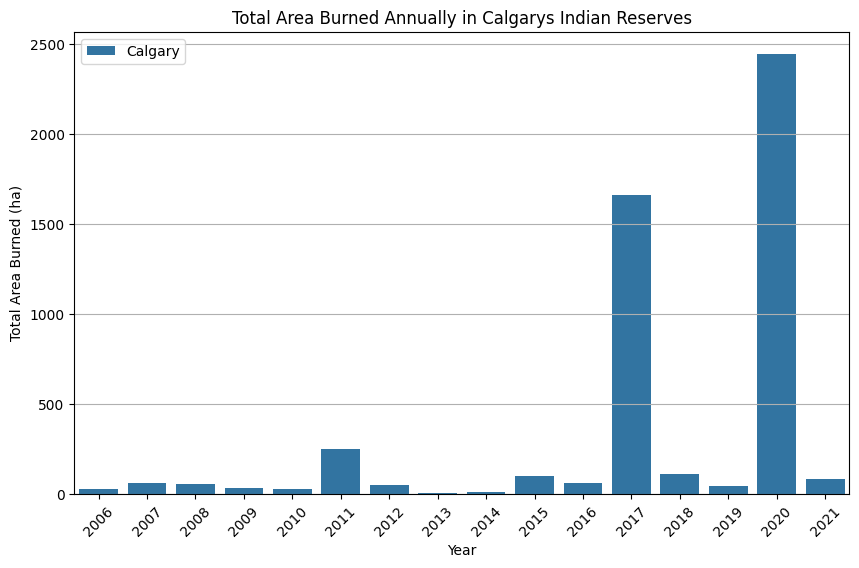

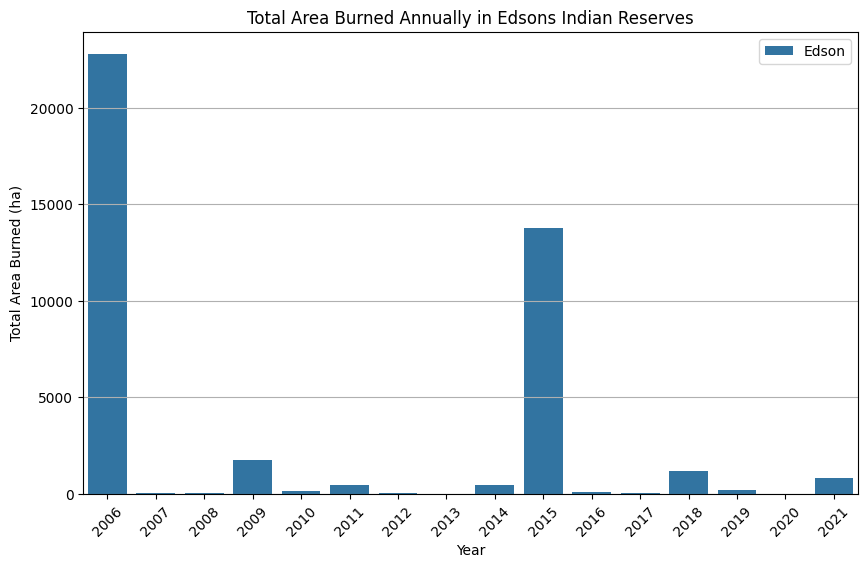

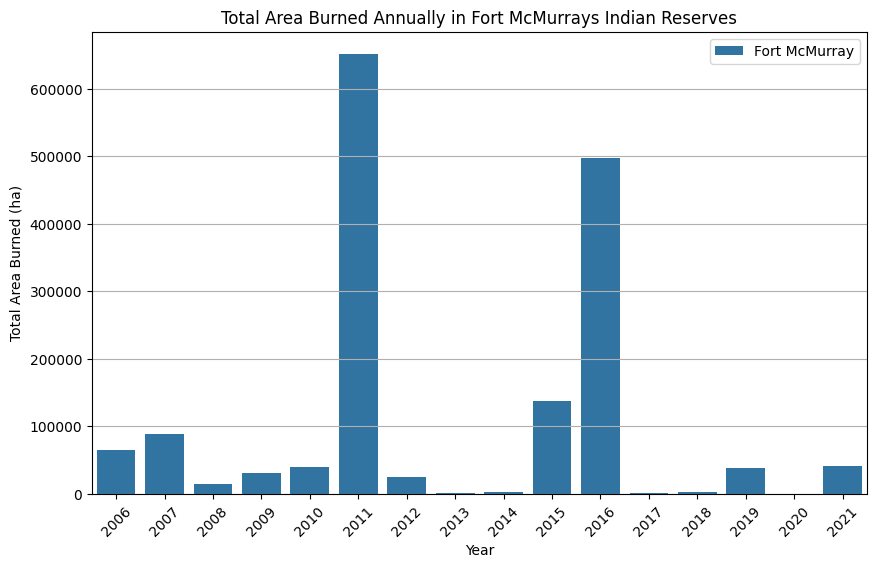

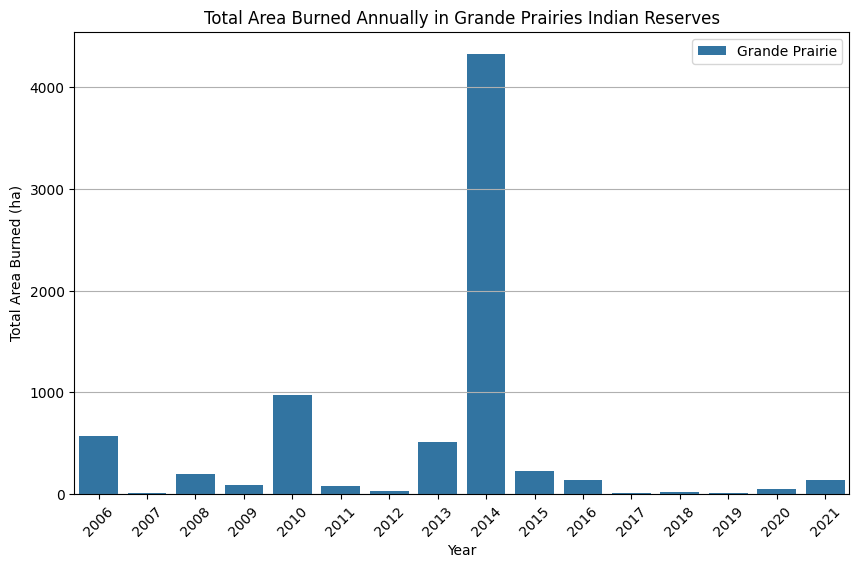

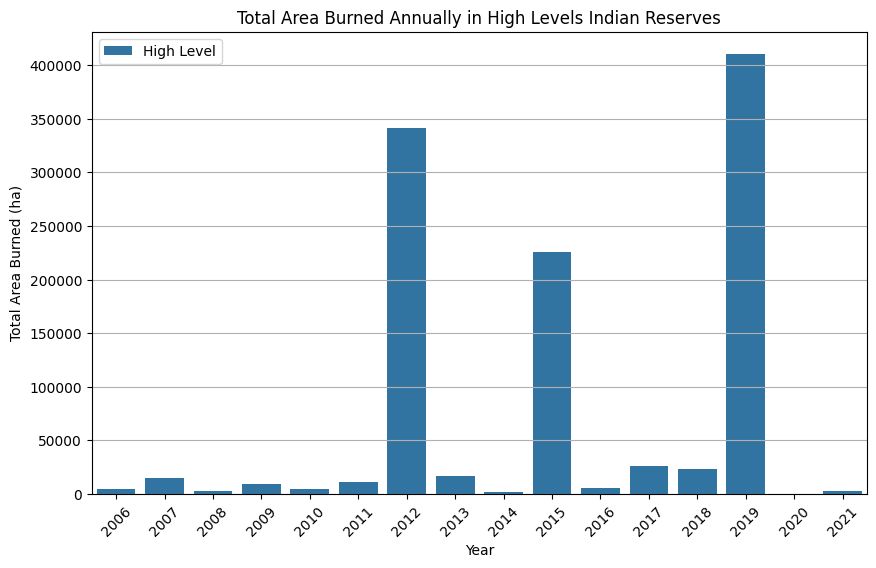

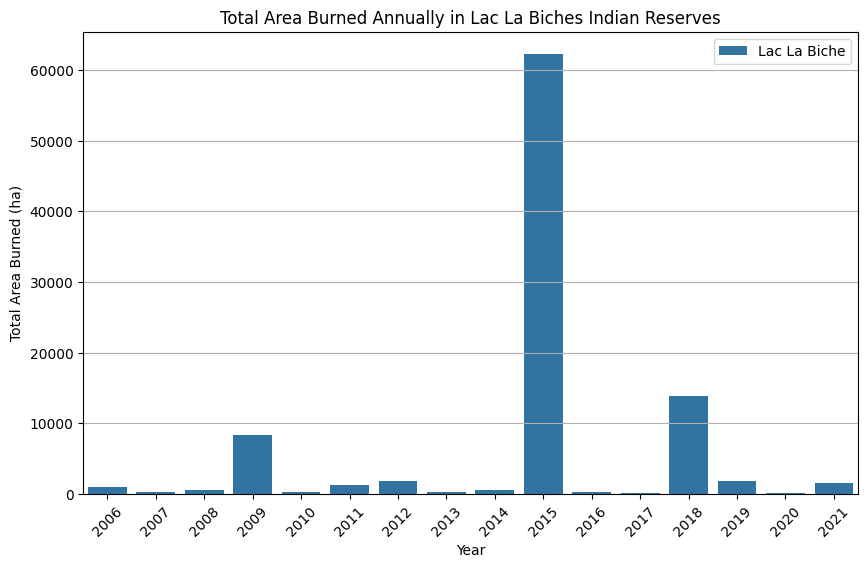

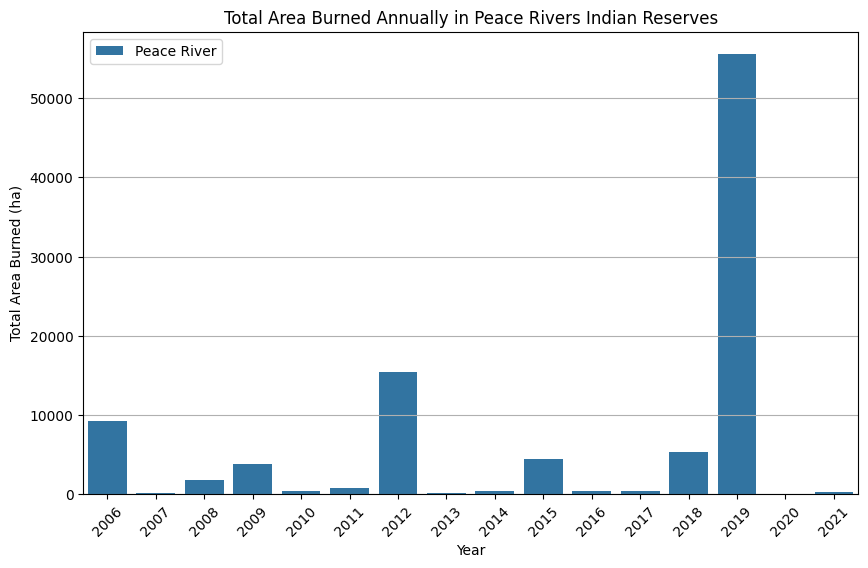

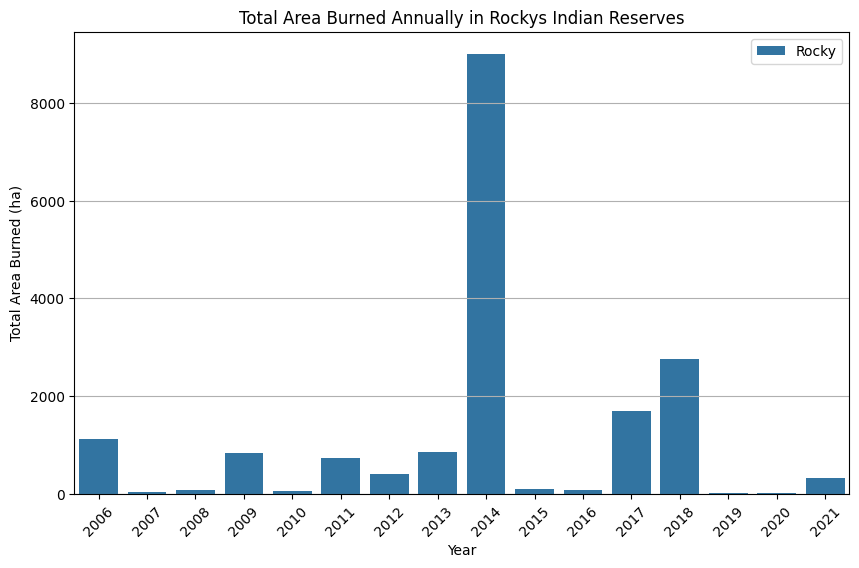

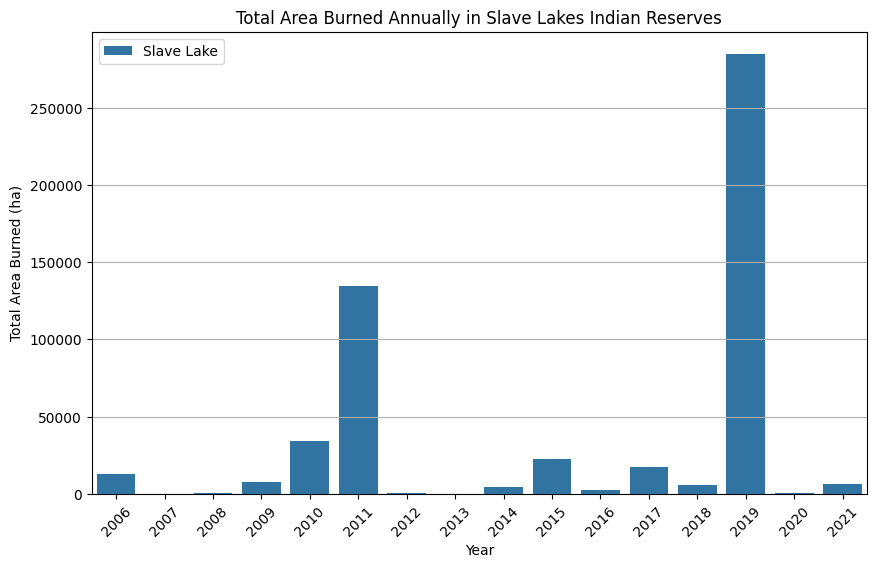

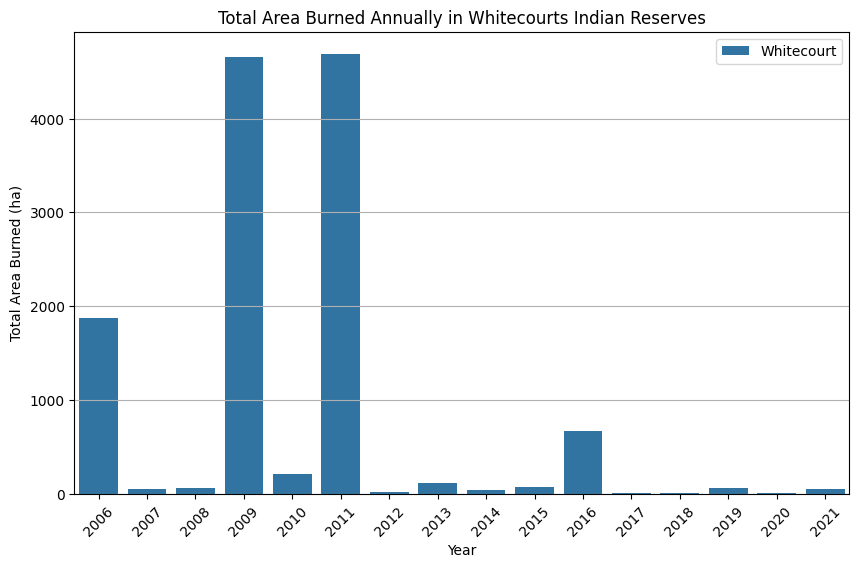

In [ ]:
seasonality_data2 = df_ID2.groupby(['region_name', 'fire_year'])['current_size'].sum().reset_index(name='total_area_burned')

# Plotting
for region_name in seasonality_data2['region_name'].unique():
    # Filter data for the current region
    region_data = seasonality_data2[seasonality_data2['region_name'] == region_name]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=region_data, x='fire_year', y='total_area_burned', label=region_name)

    plt.title(f'Total Area Burned Annually in {region_name}s Indian Reserves')
    plt.xlabel('Year')
    plt.ylabel('Total Area Burned (ha)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid(axis='y')  # Add a horizontal grid for easier comparison
    plt.show()
